# Módulo 1: Análisis de datos en el ecosistema Python

### Sesión (26)

**18/03/2023**

# Modelado estadístico

El modelado estadístico (***Statistical Modeling***) en series temporales se refiere a la aplicación de **métodos estadísticos** para analizar y modelar los datos secuenciales.

El modelado estadístico de series temporales implica **seleccionar** un modelo apropiado en función de las características de los datos, **ajustar** el modelo a los datos y **utilizar** el modelo para hacer **predicciones** o probar hipótesis.

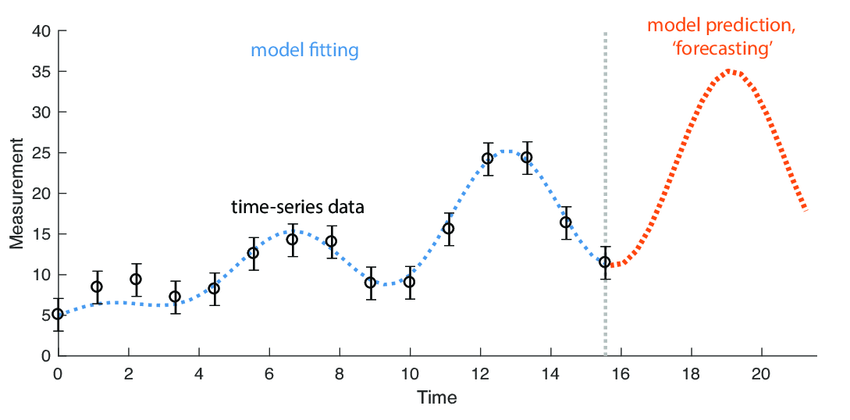

In [1]:
# importamos las librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Modificamos los parámetros de los gráficos en matplotlib
from matplotlib.pyplot import rcParams

rcParams['figure.figsize'] = 12, 6 # el primer dígito es el ancho y el segundo el alto
rcParams["font.weight"] = "bold"
rcParams["font.size"] = 10
rcParams["axes.labelweight"] = "bold"

### Airline Passenger Dataset

Importamos los datos del ejemplo disponible en la librería ___seaborn___ que contiene el número total de pasajeros aéreos de forma mensual.

In [3]:
import seaborn as sns
import pandas as pd

# Cargar el dataset de "flights"
df_air = sns.load_dataset('flights')
df_air

year month  passengers
0    1949   Jan         112
1    1949   Feb         118
2    1949   Mar         132
3    1949   Apr         129
4    1949   May         121
..    ...   ...         ...
139  1960   Aug         606
140  1960   Sep         508
141  1960   Oct         461
142  1960   Nov         390
143  1960   Dec         432

[144 rows x 3 columns]

In [4]:
# Consultamos la información del dataset descargado
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [5]:
# Crear una nueva columna con la unificación de otras dos
df_air['year_month'] = df_air.apply(lambda x: str(x['year']) + '-' + x['month'], axis=1)

# Convertir la columna en fechas tipo DatetimeIndex
df_air['fechas'] = pd.to_datetime(df_air['year_month'], format='%Y-%b')

# Convertir la columna de fechas a los índices del DataFrame e indicar que los datos son "mensuales"
df_air.set_index('fechas', inplace=True)
df_air.index.freq = 'MS'

# Quitar las columnas no necesarias
df_air.drop(columns=['year', 'month', 'year_month'], inplace=True)

df_air

passengers
fechas                
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

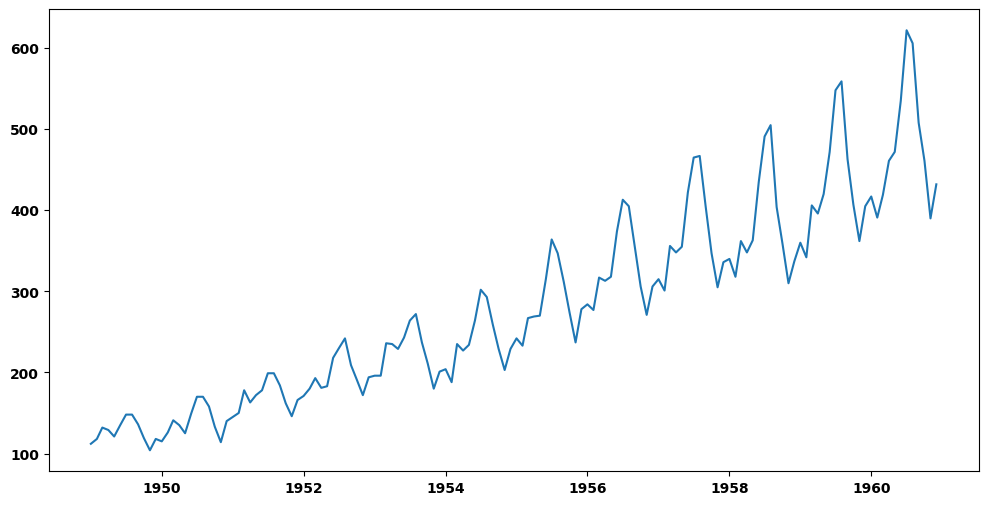

In [6]:
# Visualizar el DataFrame creado con los datos de la serie temporal
plt.plot(df_air)
plt.show()

In [7]:
# Gráfica interactiva con Plotly
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_air.index,
    y=df_air['passengers'],
    mode="markers+lines"
    ))

fig.update_layout(title="Número de pasajeros aéreos de cada mes desde el año 1949 al 1960",
                  title_font_size=26,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Pasajeros'
                  )

fig.show()

## Time Series Forecasting

#### Preparación de conjuntos de entrenamiento y prueba:

En primer lugar debemos crear **dos conjuntos diferentes** para poder **entrenar el modelo** con uno y poder analizar los resultados del modelo en un **periodo de prueba**, del modo que para el modelo **cuente como _"futuro"_**.

El tamaño mínimo del **conjunto de test tiene que cubrir el horizonte de predicción**. Procedemos a crear modelos que sean capaces de predecir los próximos 12 meses. 

- **Test**: El último año
- **Training**: Todo el histórico salvo el último año

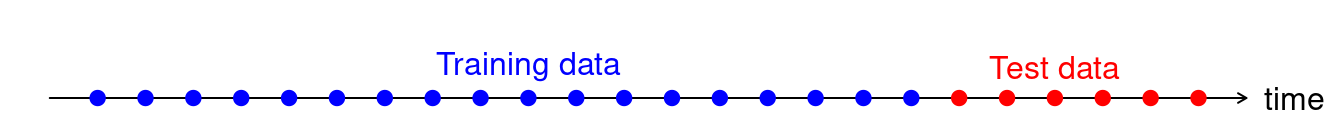

In [8]:
# Definir el periodo de prueba (horizonte de predicción)
horizonte = 12  # La cantidad de puntos a predecir
df_test = df_air.tail(horizonte)
df_test

passengers
fechas                
1960-01-01         417
1960-02-01         391
1960-03-01         419
1960-04-01         461
1960-05-01         472
1960-06-01         535
1960-07-01         622
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

In [9]:
# Consultamos el filtro por índices o fechas en este caso
df_air.index.isin(df_test.index)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [10]:
# Filtrar la serie original para sacar el periodo de entrenamiento
df_train = df_air.loc[df_air.index.isin(df_test.index)==False]
df_train

passengers
fechas                
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1959-08-01         559
1959-09-01         463
1959-10-01         407
1959-11-01         362
1959-12-01         405

[132 rows x 1 columns]

In [11]:
# Podemos invertir la máscara booleana que se ha generado antes
~df_air.index.isin(df_test.index)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [12]:
# Podemos filtrarlos de otra manera
df_train = df_air.loc[~df_air.index.isin(df_test.index)]
df_train

passengers
fechas                
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1959-08-01         559
1959-09-01         463
1959-10-01         407
1959-11-01         362
1959-12-01         405

[132 rows x 1 columns]

In [13]:
# Comprobar las dimensiones de los conjuntos de datos creados
print("tamaño del dataset: ", len(df_air))
print("tamaño de los datos de entrenamiento: ", len(df_train))
print("tamaño de los datos de test: ", len(df_test))

tamaño del dataset:  144
tamaño de los datos de entrenamiento:  132
tamaño de los datos de test:  12


Visualizamos de forma interactiva los periodos marcados como entrenamiento y prueba.

In [14]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['passengers'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['passengers'],
    name="Test",
    mode="markers+lines"
    ))


fig.update_layout(title="Número de pasajeros aéreos de cada mes desde el año 1949 al 1960",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Pasajeros'
                  )

fig.show()

### **Benchmark Models**

En el proceso de modelado, los modelos de referencia (***benchmarks***) son modelos simples y fáciles de implementar que sirven como referencia para **evaluar el rendimiento de modelos más complejos**.

Los modelos de referencia se utilizan a menudo para **establecer un nivel mínimo de rendimiento** que debe superar un modelo más complejo para que se considere útil.

### Average Model

En este primer modelo básico, las predicciones de todos los valores futuros son iguales al _promedio_ (**"media"**) de los datos históricos.

In [15]:
# Calcular la media de los valores históricos
df_train.mean()

passengers    262.492424
dtype: float64

In [16]:
# Crear predicciones iguales al promedio
media = df_train.mean().values[0]
pred_avg = pd.DataFrame(data=[media]*df_test.size, index=df_test.index, columns=['pred'])
pred_avg

pred
fechas                
1960-01-01  262.492424
1960-02-01  262.492424
1960-03-01  262.492424
1960-04-01  262.492424
1960-05-01  262.492424
1960-06-01  262.492424
1960-07-01  262.492424
1960-08-01  262.492424
1960-09-01  262.492424
1960-10-01  262.492424
1960-11-01  262.492424
1960-12-01  262.492424

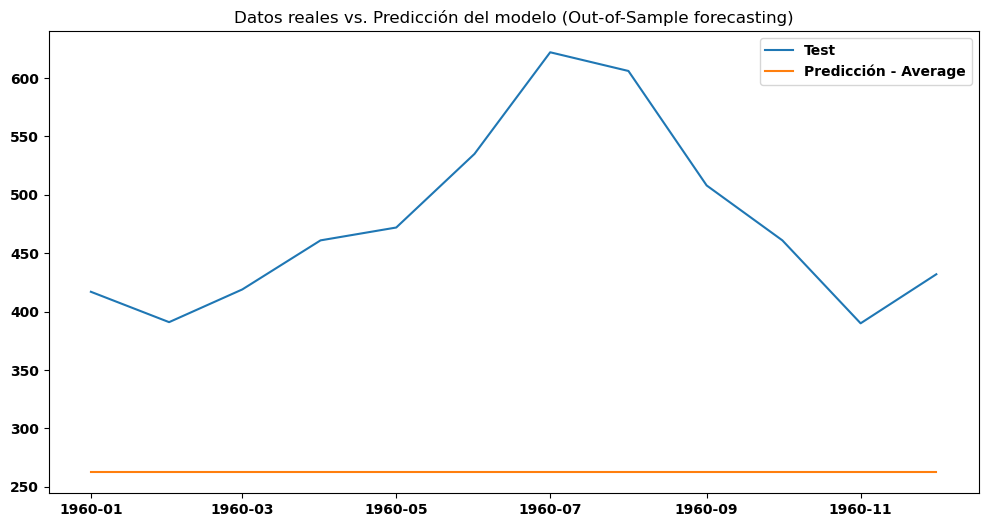

In [17]:
plt.plot(df_test, label='Test')
plt.plot(pred_avg, label='Predicción - Average')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

Creamos la gráfica de _plotly_, donde claramente se ve que este modelo tiene una caída considerable en las predicciones de la serie temporal.

In [18]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['passengers'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['passengers'],
    name="Test",
    mode="lines"
    ))


fig.add_trace(go.Scatter(
    x=pred_avg.index,
    y=pred_avg['pred'],
    name="Predicción (Average Model)",
    mode="markers+lines"
    ))



fig.update_layout(title="Número de pasajeros aéreos de cada mes desde el año 1949 al 1960",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Pasajeros'
                  )

fig.show()

### Naïve model (**Random Walk**)


El método ***Naïve*** o la **persistencia**, simplemente considera que todas las predicciones son iguales que al valor de la **última observación**. Este método funciona **sorprendentemente bien** para muchas series temporales `económicas` y `financieras`.

Debido a que un pronóstico ingenuo es óptimo cuando los datos siguen un recorrido aleatorio, también se denominan como ***random walk***.

In [19]:
# Sacar el último valor de la serie de entrenamiento
df_train.tail(1)

passengers
fechas                
1959-12-01         405

In [20]:
# Crear las predicciones para el modelo "random walk"
ultimo = df_train.tail(1).values[0]
pred_rw = pd.DataFrame(data=[ultimo]*df_test.size, index=df_test.index, columns=['pred'])
pred_rw

pred
fechas          
1960-01-01   405
1960-02-01   405
1960-03-01   405
1960-04-01   405
1960-05-01   405
1960-06-01   405
1960-07-01   405
1960-08-01   405
1960-09-01   405
1960-10-01   405
1960-11-01   405
1960-12-01   405

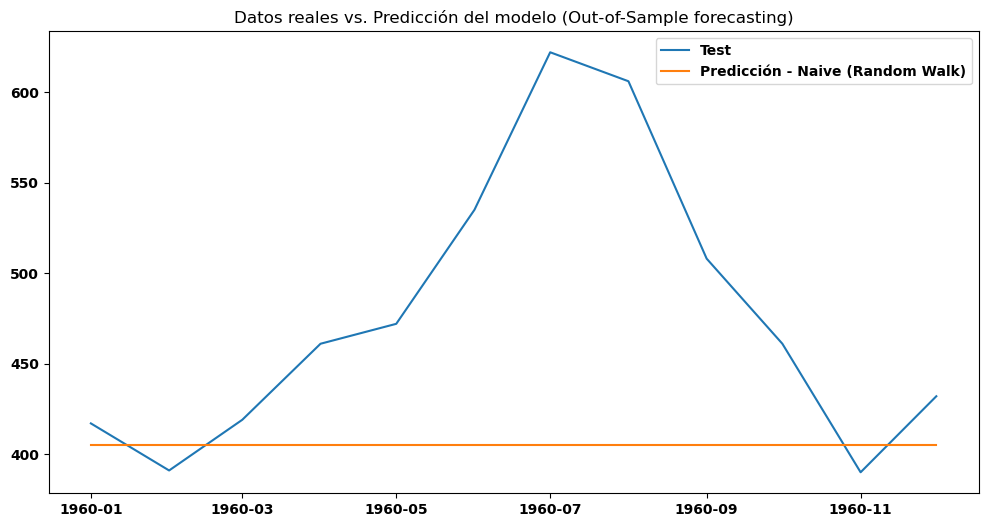

In [21]:
plt.plot(df_test, label='Test')
plt.plot(pred_rw, label='Predicción - Naive (Random Walk)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

Podemos observar que respecto al modelo anterior, al menos no presenciamos una caída en el nivel de los valores predichos.

In [22]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['passengers'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['passengers'],
    name="Test",
    mode="lines"
    ))


fig.add_trace(go.Scatter(
    x=pred_rw.index,
    y=pred_rw['pred'],
    name="Predicción (Random Walk)",
    mode="markers+lines"
    ))



fig.update_layout(title="Número de pasajeros aéreos de cada mes desde el año 1949 al 1960",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Pasajeros'
                  )

fig.show()

### Drift Model

Una variación del método ingenuo (_random walk_) es permitir que los valores a predecir aumenten o disminuyan con el tiempo, donde la cantidad de cambio con el tiempo se establece como el **cambio promedio observado** en los datos históricos.

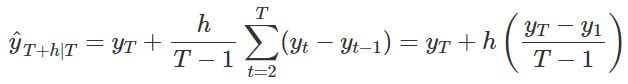



Esto es equivalente a trazar **una línea entre la primera y la última observación** y extrapolarla al futuro.

In [23]:
# Calcular las predicciones del método "random walk with drift"
pendiente = (df_train.values[-1] - df_train.values[0]) / (len(df_train) - 1)
datos_drift = [df_train.values[-1] + pendiente*x for x in range(1, horizonte+1)]
pred_drift = pd.DataFrame(data=datos_drift, index=df_test.index, columns=['pred'])
pred_drift

pred
fechas                
1960-01-01  407.236641
1960-02-01  409.473282
1960-03-01  411.709924
1960-04-01  413.946565
1960-05-01  416.183206
1960-06-01  418.419847
1960-07-01  420.656489
1960-08-01  422.893130
1960-09-01  425.129771
1960-10-01  427.366412
1960-11-01  429.603053
1960-12-01  431.839695

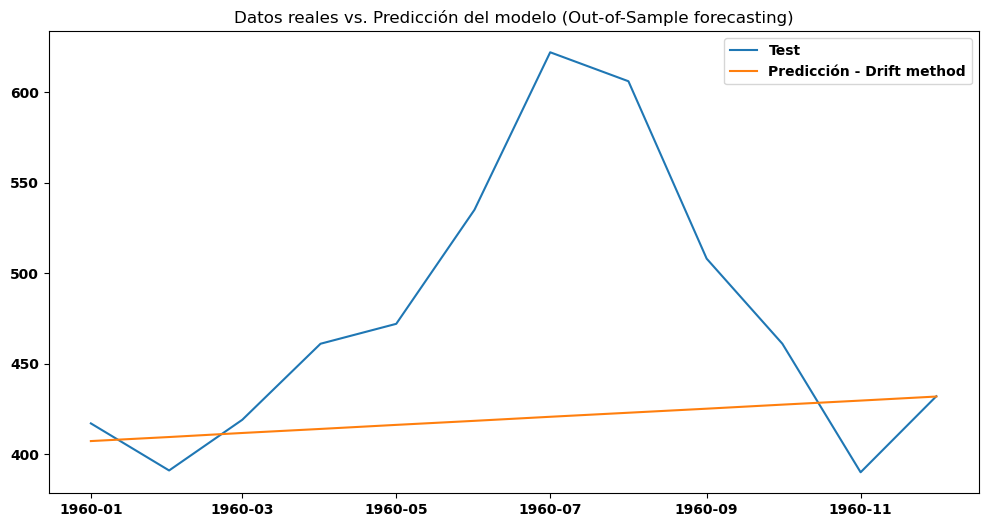

In [24]:
plt.plot(df_test, label='Test')
plt.plot(pred_drift, label='Predicción - Drift method')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

Se ve que el nivel de los valores predichos aumenta a lo largo del tiempo, de acuerdo al cambio incremental en el nivel de la serie temporal.

In [25]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['passengers'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['passengers'],
    name="Test",
    mode="lines"
    ))


fig.add_trace(go.Scatter(
    x=pred_drift.index,
    y=pred_drift['pred'],
    name="Predicción (Drift)",
    mode="markers+lines"
    ))


fig.update_layout(title="Número de pasajeros aéreos de cada mes desde el año 1949 al 1960",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Pasajeros'
                  )

fig.show()

### Seasonal Naïve model

Un método útil para datos altamente estacionales consiste en que cada predicción sea igual al último valor observado de la misma temporada, por ejemplo el mismo mes del año anterior. 

In [26]:
# Sacar el último periodo (el último año) de la serie de entrenamiento
df_train.tail(12)

passengers
fechas                
1959-01-01         360
1959-02-01         342
1959-03-01         406
1959-04-01         396
1959-05-01         420
1959-06-01         472
1959-07-01         548
1959-08-01         559
1959-09-01         463
1959-10-01         407
1959-11-01         362
1959-12-01         405

In [27]:
pred_sn = pd.DataFrame(data=df_train.tail(12).values, index=df_test.index, columns=['pred'])
pred_sn

pred
fechas          
1960-01-01   360
1960-02-01   342
1960-03-01   406
1960-04-01   396
1960-05-01   420
1960-06-01   472
1960-07-01   548
1960-08-01   559
1960-09-01   463
1960-10-01   407
1960-11-01   362
1960-12-01   405

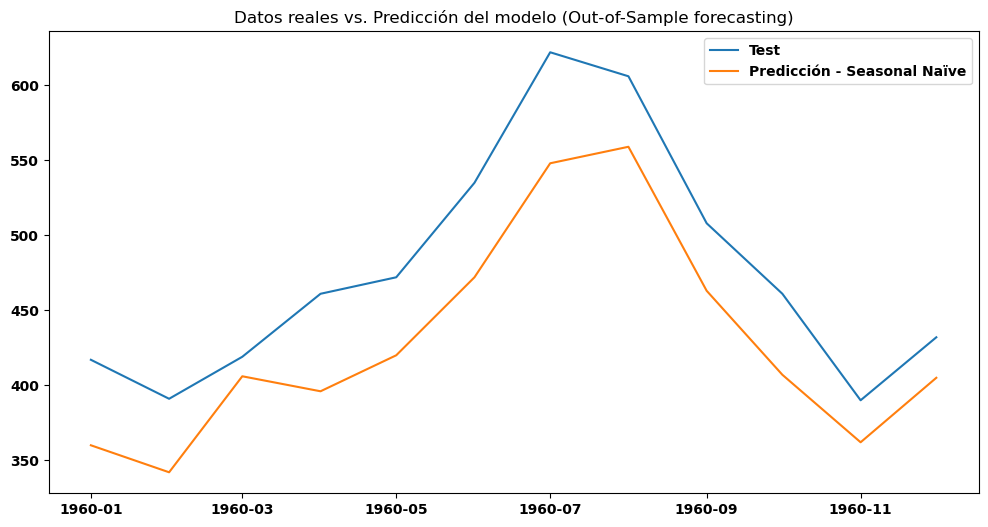

In [28]:
plt.plot(df_test, label='Test')
plt.plot(pred_sn, label='Predicción - Seasonal Naïve')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

Se puede apreciar que **la replica del año anterior** sigue mucho mejor la evolución de los valores reales. Sin embargo, claramente existe un **sesgo en la predicción** por no contar con el aumento en el nivel de los pasajeros en egeneral de acuerdo a la **tendencia global** de la serie temporal.  

In [29]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['passengers'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['passengers'],
    name="Test",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_sn.index,
    y=pred_sn['pred'],
    name="Predicción (Seasonal Naive)",
    mode="markers+lines"
    ))

fig.update_layout(title="Número de pasajeros aéreos de cada mes desde el año 1949 al 1960",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Pasajeros'
                  )

fig.show()

### **In-Sample** Model Evaluation

La evaluación dentro de la muestra (_In-sample evaluation_) consiste en **evaluar las estimaciones del modelo** para el mismo conjunto de **datos utilizados en el proceso de entrenamiento**. Si bien esta evaluación proporciona información sobre qué tan bien se ajusta el modelo a los datos disponibles, **no ofrece una información** respecto a la **capacidad de generalización del modelo** a los datos nuevos y no vistos anteriormente.

Algunas medidas comunes utilizadas para evaluar el ajuste dentro de la muestra de un modelo de serie temporal incluyen:

- **Valores residuales**: Los errores de predicción en el conjunto de entrenamiento son los valores residuales del modelo que deben estar **en torno a cero** y **no deben exhibir ningún patrón** concreto.

- **Calidad de ajuste (_Goodness-of-fit_)**: El coeficiente de **R-cuadrado**, el criterio de información de Akaike (**AIC**), el criterio de información bayesiano (**BIC**) son estadísticas que se pueden utilizar para **comparar el ajuste de diferentes modelos** y seleccionar el mejor modelo. Tanto _AIC_ como _BIC_ son medidas de la **compensación entre la calidad de ajuste del modelo y la complejidad** del mismo. Cuanto **menor** sea la puntuación _AIC_ o _BIC_, **mejor** se ajustará el modelo a los datos.

La evaluación dentro del periodo de entrenamiento **no debe usarse como el único criterio** para seleccionar un modelo de serie temporal. El sobreajuste o el ___Overfitting___ puede ocurrir cuando un modelo es **demasiado complejo** y se ajusta demasiado bien a los datos disponibles, lo que da como resultado **un rendimiento muy pobre de generalización** en datos nuevos. Por lo tanto, la evaluación fuera de la muestra (_Out-of-sample evaluation_) es esencial para valorar la calidad de los modelos de series temporales.

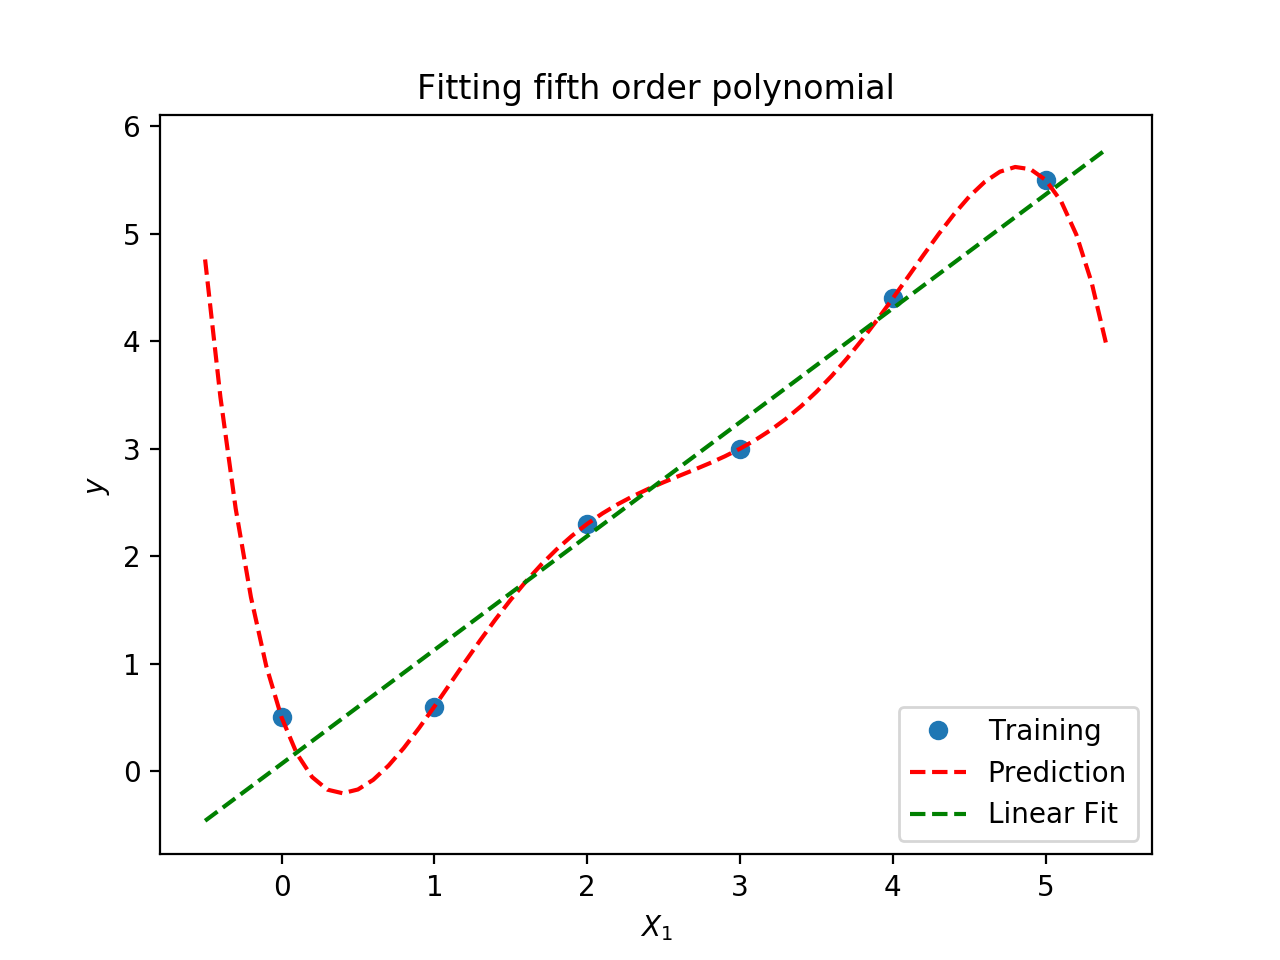

#### Forecasing accuracy

Hay diferentes métricas para **evaluar las predicciones generadas** por un modelo de series temporales **al igual que los modelos de regresión**. La mayoría de estas medidas se basan en la **similitud de los valores predichos con reales**. 

**El error de un modelo de series temporales** es la diferencia entre los datos reales y las predicciones del modelo. El error puede ser determinado de multiples maneras:

- Error medio absoluto (**MAE**) es la media del valor absoluto de los errores. 
- Error cuadrático medio (**MSE**) es la media de los errores al cuadrado. 
- Error medio absoluto porcentual (**MAPE**) es la media del porcentaje de errores absoluto. Nos hace una idea sobre el porcentaje de error, aunque no funciona tan bien si tenemos datos cerca de cero. 
- Raiz cuadrada del error cuadrático medio (**RMSE**) es la raíz cuadrada de la anterior medida.

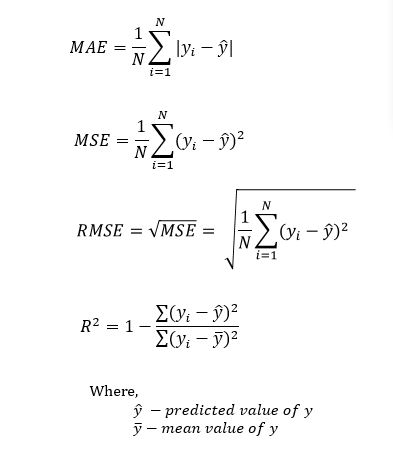

**R-cuadrado** (también se conoce como **coeficiente de determinación**) no es un error, sino una métrica popular para la precisión del modelo. Determina la **`capacidad de un modelo para predecir futuros resultados`**, es decir, representa como de cerca a realidad están los valores de los datos de la línea de regresión ajustada. 

El mejor resultado posible es 1.0, y ocurre cuando la predicción coincide con los valores de la variable objetivo. $R^{2}$ puede tomar valores negativos pues la predicción puede ser arbitrariamente mala. Cuanto **más alto sea el $R^{2}$, mejor** encaja el modelo a los datos.

Ahora consultamos las métricas de calidad de cada modelo sobre el periodo de prueba, del mismo modo de modelos de **regresión** mediante la librería _sklearn_:

In [30]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas de evaluación del modelo
print("Out-of-sample performance:  Average Model")
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_avg))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_avg)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_avg))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_avg)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_avg))

Out-of-sample performance:  Average Model
Mean Absolute Error (MAE): 213.6742424242425
Mean Absolute Percentage Error (MAPE): 43.62152220711003
Mean Squared Error (MSE): 51196.154097796134
Root Mean Squared Error (RMSE): 226.26567149657532
R^2 coefficient of determination: -8.242063511469008


La librería _statsmodels_ también dispone de métodos propios para sacar algunas de estas métricas:

In [31]:
from statsmodels.tools.eval_measures import meanabs
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import rmse

print("Out-of-sample performance:  Average Model")
print('Mean Absolute Error (MAE) by (statsmodels):', meanabs(df_test, pred_avg))
print('Mean Squared Error (MSE) by (statsmodels):', mse(df_test, pred_avg))
print('Root Mean Squared Error (RMSE) by (statsmodels):', rmse(df_test, pred_avg))

Out-of-sample performance:  Average Model
Mean Absolute Error (MAE) by (statsmodels): [213.67424242]
Mean Squared Error (MSE) by (statsmodels): [51196.1540978]
Root Mean Squared Error (RMSE) by (statsmodels): [226.2656715]


In [32]:
# Métricas de evaluación del modelo
print("Out-of-sample performance:  Random Walk (persistencia)")
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_rw))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_rw)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_rw))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_rw)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_rw))

Out-of-sample performance:  Random Walk (persistencia)
Mean Absolute Error (MAE): 76.0
Mean Absolute Percentage Error (MAPE): 14.251338486772209
Mean Squared Error (MSE): 10604.166666666666
Root Mean Squared Error (RMSE): 102.97653454387881
R^2 coefficient of determination: -0.9142918749780613


In [33]:
# Métricas de evaluación del modelo
print("Out-of-sample performance:  Drift method")
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_drift))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_drift)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_drift))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_drift)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_drift))

Out-of-sample performance:  Drift method
Mean Absolute Error (MAE): 66.30788804071248
Mean Absolute Percentage Error (MAPE): 12.417957002111175
Mean Squared Error (MSE): 8587.054911329953
Root Mean Squared Error (RMSE): 92.66636342994126
R^2 coefficient of determination: -0.5501575902632034


In [34]:
# Métricas de evaluación del modelo
print("Out-of-sample performance:  Seasonal Naive")
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_sn))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_sn)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_sn))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_sn)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_sn))

Out-of-sample performance:  Seasonal Naive
Mean Absolute Error (MAE): 47.833333333333336
Mean Absolute Percentage Error (MAPE): 9.987532920823485
Mean Squared Error (MSE): 2571.3333333333335
Root Mean Squared Error (RMSE): 50.708316214732804
R^2 coefficient of determination: 0.5358161878638659


**Benchmark results**

Como podemos observar estos modelos de referncia generan un rendimiento de base que por ser superado por otros modelos pueden indicar la utilidad de usarlos. Graficamos el error absoluto medio en la predicción del último año con estos modelos de Benchmarks:

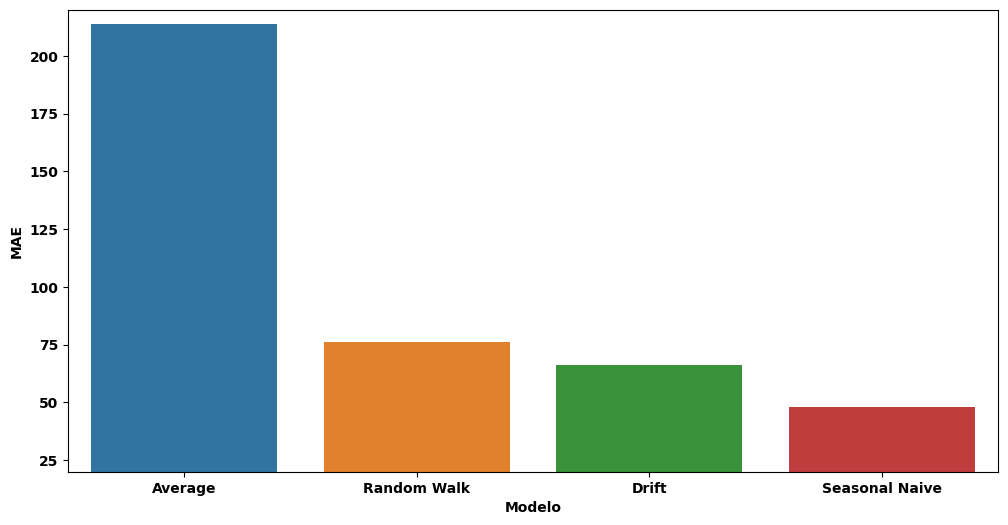

In [35]:
df_metricas = pd.DataFrame({"Modelo": ['Average', 'Random Walk', 'Drift', 'Seasonal Naive'],
                            "MAE": [213.67, 76.0, 66.31, 47.83]})

sns.barplot(data=df_metricas, x=df_metricas['Modelo'], y=df_metricas['MAE'])
plt.ylim(20,220)
plt.show()

---

### Modelos de Autoregresión (AR)

Los modelos tipo AR (**Autoregressive Models**), son un enfoque popular para la previsión de series temporales que se basa en la idea de que **los valores pasados de una serie temporal se pueden utilizar para predecir sus valores futuros**. Es decir, el valor de un paso de tiempo dado se modela como una **combinación lineal de sus valores pasados**, y los coeficientes de la combinación lineal se estiman a partir de los datos disponibles en el periodo de entrenamiento.

El método **`AutoReg`** tiene un parámetro como el orden de la autorregresión (___p___) que determina el **número de valores pasados** de la serie temporal que se utilizan para predecir el valor actual.

Este se puede escribir como:

$y_t = c + φ_1y(t-1) + φ_2y(t-2) + … + φ_p*y(t-p) + ε_t$

donde $y_t$ es el valor de la serie temporal en el tiempo $t$, $c$ es un término constante, $φ_1, φ_2, …, φ_p$ son los coeficientes autorregresivos y $ε_t$ es un término de error de ruido blanco. Estos coeficientes autorregresivos se estiman mediante el método de máxima verosimilitud (_Maximum Likelihood_) o regresión de mínimos cuadrados (_OLS_).

Como sabemos que nuestros datos tienen una dependencia a los valores pasados generamos un modelo ___AR(12)___

In [36]:
from statsmodels.tsa.ar_model import AutoReg

modelo_ar = AutoReg(df_train, lags=12)
modelo_ar

In [37]:
# Ajustar el modelo a los datos de entrenamiento
fit_ar = modelo_ar.fit()
fit_ar


El método `.summary()` en muchos modelos de la librería `statsmodels` proporciona un resumen de los resultados y la calidad del modelo ajustado:

- **Modelo**: Esta sección proporciona una breve descripción del modelo, incluida la variable dependiente, el método utilizado para ajustar el modelo y el número de observaciones y parámetros.

- **Criterios de información**: esta sección proporciona varios criterios de información, como el criterio de información de Akaike (_AIC_) y el criterio de información bayesiano (_BIC_), que se pueden utilizar para comparar el ajuste de diferentes modelos.

- **Coeficientes**: esta sección enumera los coeficientes estimados para cada variable de retraso (_lags_).

In [38]:
fit_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             passengers   No. Observations:                  132
Model:                    AutoReg(12)   Log Likelihood                -477.032
Method:               Conditional MLE   S.D. of innovations             12.888
Date:                Sat, 23 Mar 2024   AIC                            982.064
Time:                        12:52:13   BIC                           1021.089
Sample:                    01-01-1950   HQIC                           997.912
                         - 12-01-1959                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.1990      3.668      2.780      0.005       3.009      17.389
passengers.L1      0.5390      0.082      6.543      0.000       0.378       0.701
passengers.L2     -0.3436      0.089     -3.844      0.000      -0.519      -0.168
passengers.L3      0.2570      0.090      2.843      0.004       0.080       0.434
passengers.L4     -0.2716      0.089     -3.066      0.002      -0.445      -0.098
passengers.L5      0.3283      0.087      3.757      0.000       0.157       0.500
passengers.L6     -0.3451      0.090     -3.847      0.000      -0.521      -0.169
passengers.L7      0.3208      0.093      3.459      0.001       0.139       0.503
passengers.L8     -0.3658      0.092     -3.975      0.000      -0.546      -0.185
passengers.L9      0.3622      0.093      3.889      0.000       0.180       0.545
passengers.L10    -0.3759      0.096     -3.898      0.000      -0.565      -0.187
passengers.L11     0.4433      0.099      4.476      0.000       0.249       0.637
passengers.L12     0.4937      0.092      5.349      0.000       0.313       0.675
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9950           -0.0000j            0.9950           -0.0000
AR.2             0.8619           -0.4889j            0.9909           -0.0821
AR.3             0.8619           +0.4889j            0.9909            0.0821
AR.4             0.5018           -0.8628j            0.9981           -0.1662
AR.5             0.5018           +0.8628j            0.9981            0.1662
AR.6             0.0173           -1.0159j            1.0160           -0.2473
AR.7             0.0173           +1.0159j            1.0160            0.2473
AR.8            -0.5235           -0.8948j            1.0367           -0.3343
AR.9            -0.5235           +0.8948j            1.0367            0.3343
AR.10           -0.9001           -0.4768j            1.0186           -0.4225
AR.11           -0.9001           +0.4768j            1.0186            0.4225
AR.12           -1.8077           -0.0000j            1.8077           -0.5000
------------------------------------------------------------------------------
"""

#### Fitted-Model Evaluation

Ahora podemos analizar hasta qué punto se ha ajustado este modelo a los datos de entrenamiento (___In-sample model evaluation___). Básicamente calculamos la estimación del modelo para cada observación en este periodo como la predicción de un paso adelante (___one-step-ahead forecast___)

Podemos extraer los valores ajustados o las estimaciones del modelo de serie temporal mediante el atributo `fittedvalues`

In [39]:
# Consultamos los valores ajustados en el periodo de entrenamiento
estim_ar = fit_ar.fittedvalues
estim_ar

fechas
1950-01-01    132.992971
1950-02-01    129.836723
1950-03-01    151.932762
1950-04-01    143.175694
1950-05-01    144.507996
                 ...    
1959-08-01    557.055471
1959-09-01    462.540049
1959-10-01    405.105360
1959-11-01    344.873367
1959-12-01    384.041941
Freq: MS, Length: 120, dtype: float64

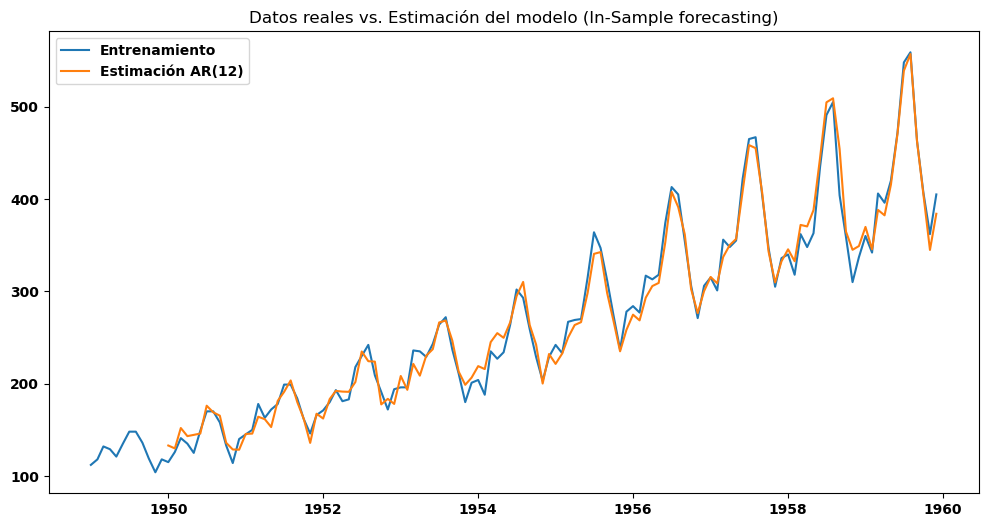

In [40]:
plt.plot(df_train, label='Entrenamiento')
plt.plot(estim_ar, label='Estimación AR(12)')
plt.title("Datos reales vs. Estimación del modelo (In-Sample forecasting)")
plt.legend()
plt.show()

Vemos que existe una diferencia entre el periodo de entrenamiento y el de valores estimados por el modelo:

In [41]:
print("La diferencia del tamaño de datos = ", len(df_train) - len(estim_ar))

La diferencia del tamaño de datos =  12


Esto pasa por la necesidad del modelo de **disponer de un conjunto mínimo de muestras** para poder generar una predicción. Otra forma de recuperar los valores ajustados por el modelo sería sacar la predicción por defecto usando el método `.predict()` que nos devuelve un **objeto con el mimo tamaño** que los datos de entrenamiento:

In [42]:
estim_ar_train = fit_ar.predict()
estim_ar_train

fechas
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
                 ...    
1959-08-01    557.055471
1959-09-01    462.540049
1959-10-01    405.105360
1959-11-01    344.873367
1959-12-01    384.041941
Freq: MS, Length: 132, dtype: float64

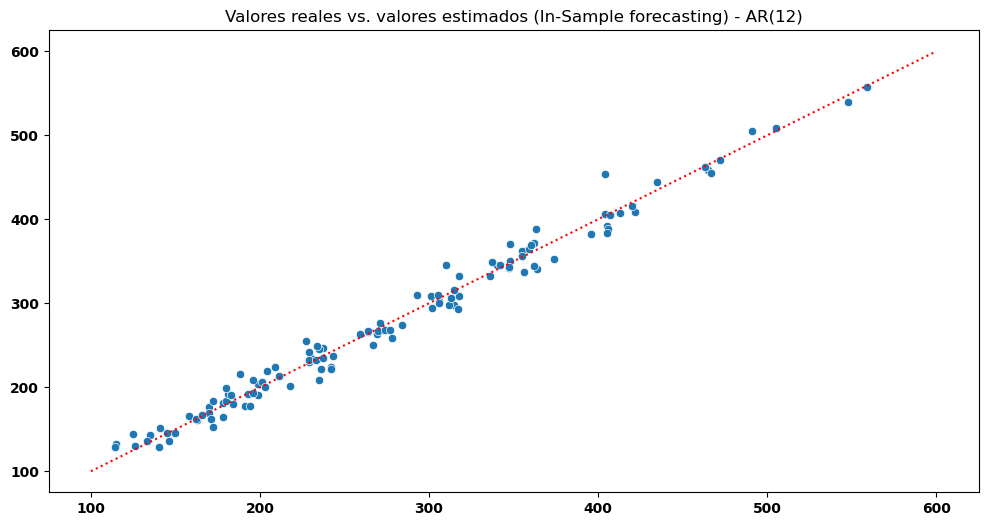

In [43]:
# Comparar los valores reales con la estimación del modelo
sns.scatterplot(x=df_train.values.flatten(), y=estim_ar_train)
plt.plot([100,600], [100,600], color='r', linestyle=':')
plt.title("Valores reales vs. valores estimados (In-Sample forecasting) - AR(12)")
plt.show()

 Vamos a analizar los errores en el periodo de entrenamiento. 

In [44]:
erorr_ar_train = pd.Series(data=df_train.values.flatten()-estim_ar_train.values.flatten(),
                           index=df_train.index)
erorr_ar_train

fechas
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
                ...    
1959-08-01     1.944529
1959-09-01     0.459951
1959-10-01     1.894640
1959-11-01    17.126633
1959-12-01    20.958059
Freq: MS, Length: 132, dtype: float64

Los errores dentro del periodo de entrenamiento, también se consideran como **valores residuales** que corresponden a la parte no capturada por el modelo. Un aspecto importante para evaluar el modelo ajustado a los datos de entrenamiento consiste en analizar las características de estos valores como el **componente residual** que idealmente serían como un **ruido blanco**:

- **`Media cero`**
- **`Varianza constante`**
- **`Autocorrelación cero`**
- **`Distribución normal`**

In [45]:
# Se pueden extraer directamente desde el modelo entrenado mediante el atributo "resid"
resid_ar = fit_ar.resid
resid_ar

fechas
1950-01-01   -17.992971
1950-02-01    -3.836723
1950-03-01   -10.932762
1950-04-01    -8.175694
1950-05-01   -19.507996
                ...    
1959-08-01     1.944529
1959-09-01     0.459951
1959-10-01     1.894640
1959-11-01    17.126633
1959-12-01    20.958059
Freq: MS, Length: 120, dtype: float64

In [46]:
# Las estadísticas del componente residual
resid_ar.describe().round(3)

count    120.000
mean       0.000
std       12.942
min      -50.228
25%       -7.419
50%        0.433
75%        8.515
max       26.321
dtype: float64

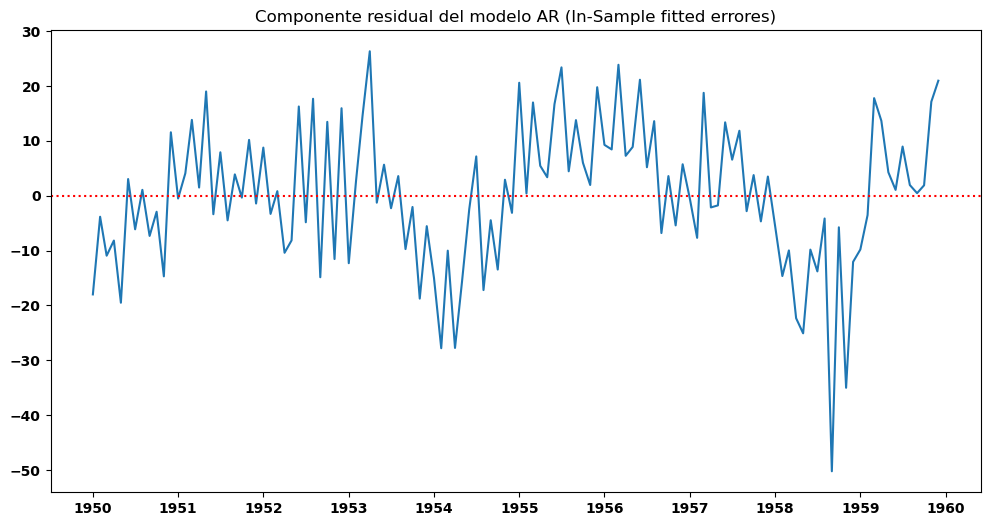

In [47]:
plt.plot(resid_ar)
plt.title("Componente residual del modelo AR (In-Sample fitted errores)")
plt.axhline(y=0, color='r', linestyle=':')
plt.show()

c:\Users\aleja\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



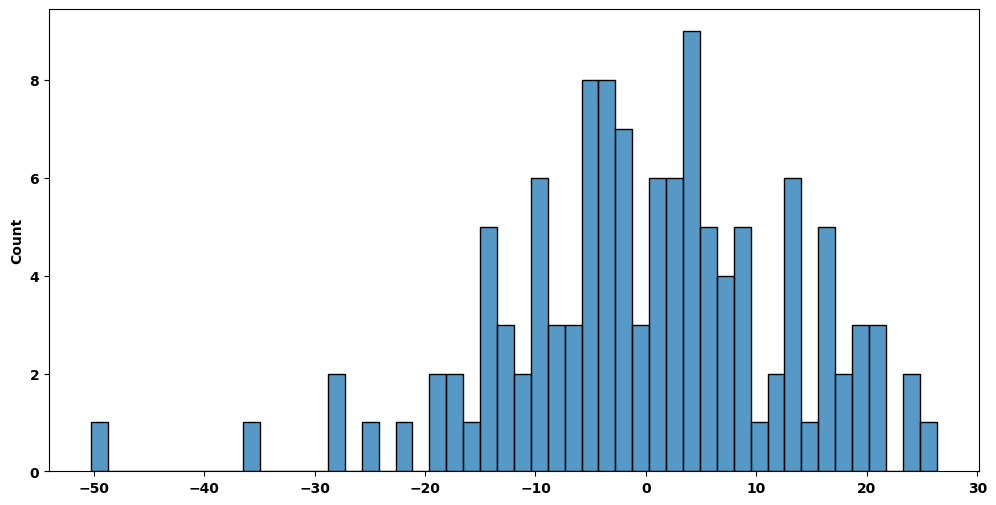

In [48]:
# El histograma del componente residual (in-sample-errors)
sns.histplot(data=resid_ar, bins=50)
plt.show()

c:\Users\aleja\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



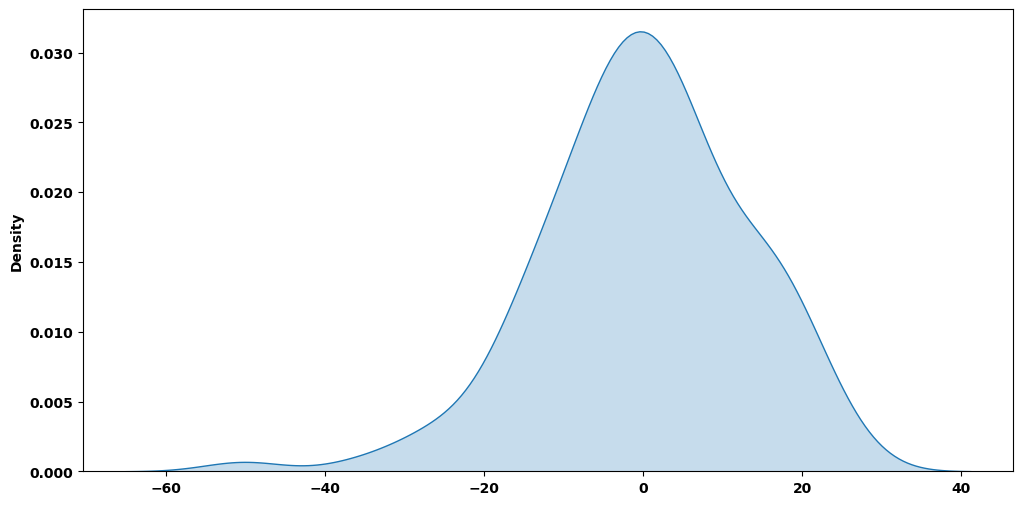

In [49]:
# La dsitribución del componente residual (in-sample-errors)
sns.kdeplot(data=resid_ar, fill=True)
plt.show()

Vemos que los residuos tienen **la media cero** y una distribución muy similar a la de **Gaussiana (distribución normal)**, nos fijamos en la varianza de estos valores. 

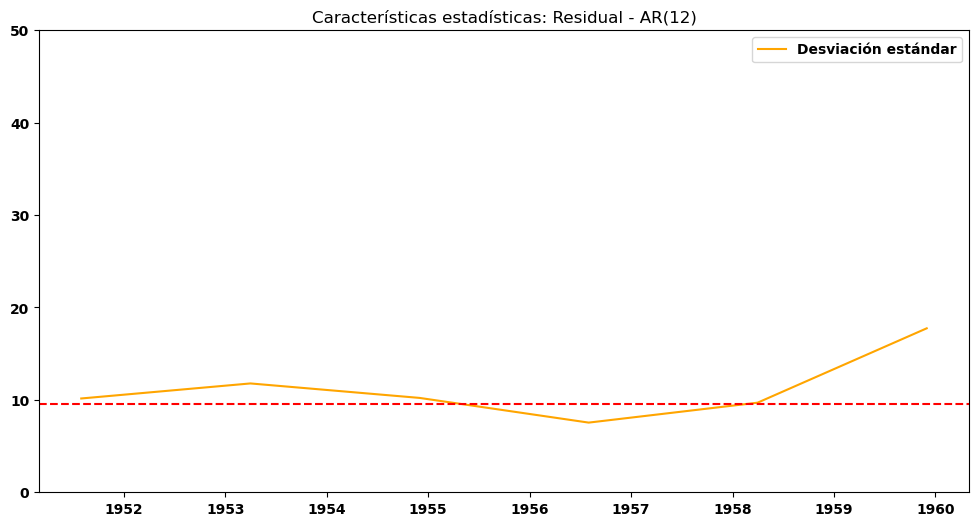

In [50]:
win = 20
resid_ar_std = resid_ar.rolling(win).std().iloc[win-1::win]
plt.plot(resid_ar_std, label='Desviación estándar', color='orange')
plt.axhline(y=9.6, color='r', linestyle='--')
plt.title("Características estadísticas: Residual - AR(12)")
plt.ylim(0,50)
plt.legend()
plt.show()

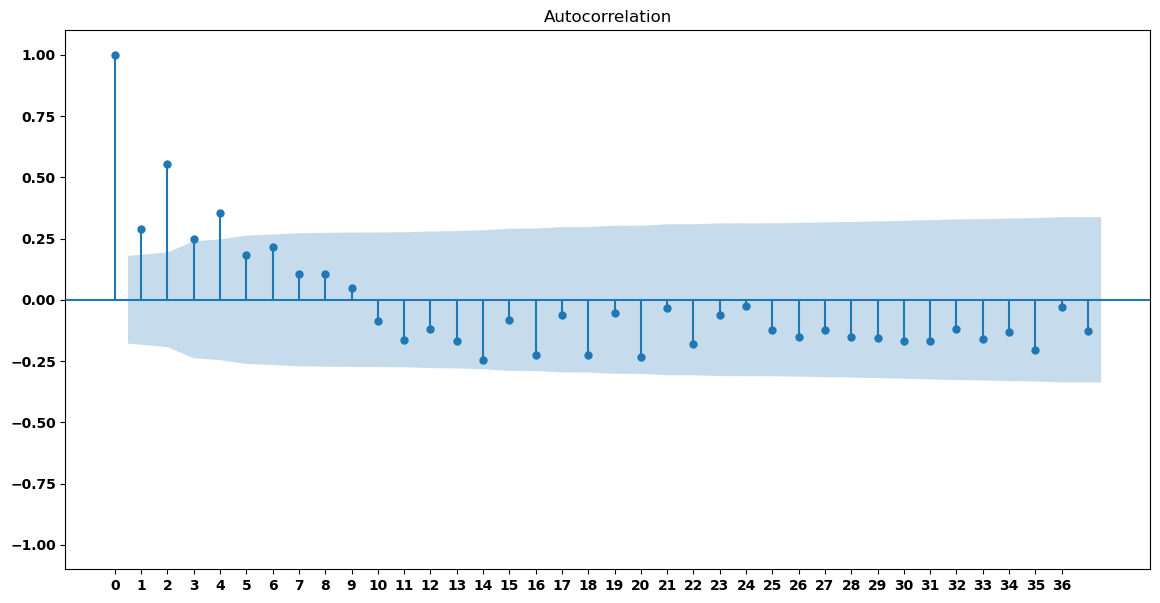

In [51]:
from statsmodels.graphics.tsaplots import plot_acf

rcParams['figure.figsize'] = 14, 7
plot_acf(resid_ar, lags=37)
plt.xticks(np.arange(37))
plt.ylim(-1.1,1.1)
plt.show()

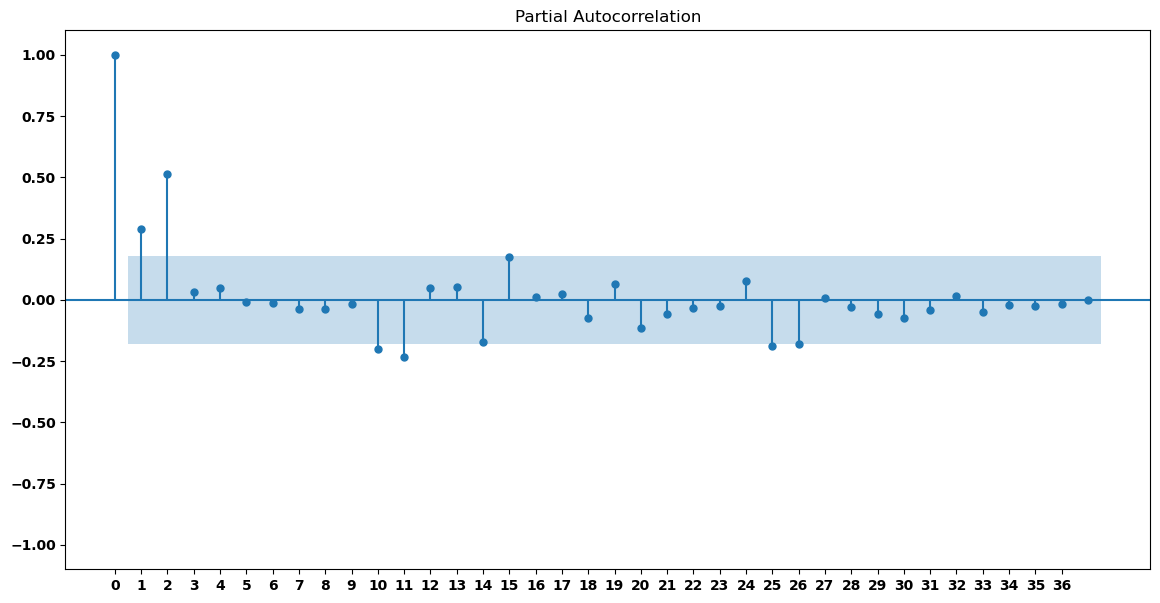

In [52]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(resid_ar, lags=37, method='ywm')
plt.xticks(np.arange(37))
plt.ylim(-1.1,1.1)
plt.show()

Además de revisar las características estadísticas del componente residual, debemos asegurarnos de que **no haya ningún patrón** entre los errores y los valores de la serie o los valores estimados.

In [53]:
# Coeficiente de correlación entre valores reales y los errores
df_train['passengers'].corr(erorr_ar_train).round(4)

0.1266

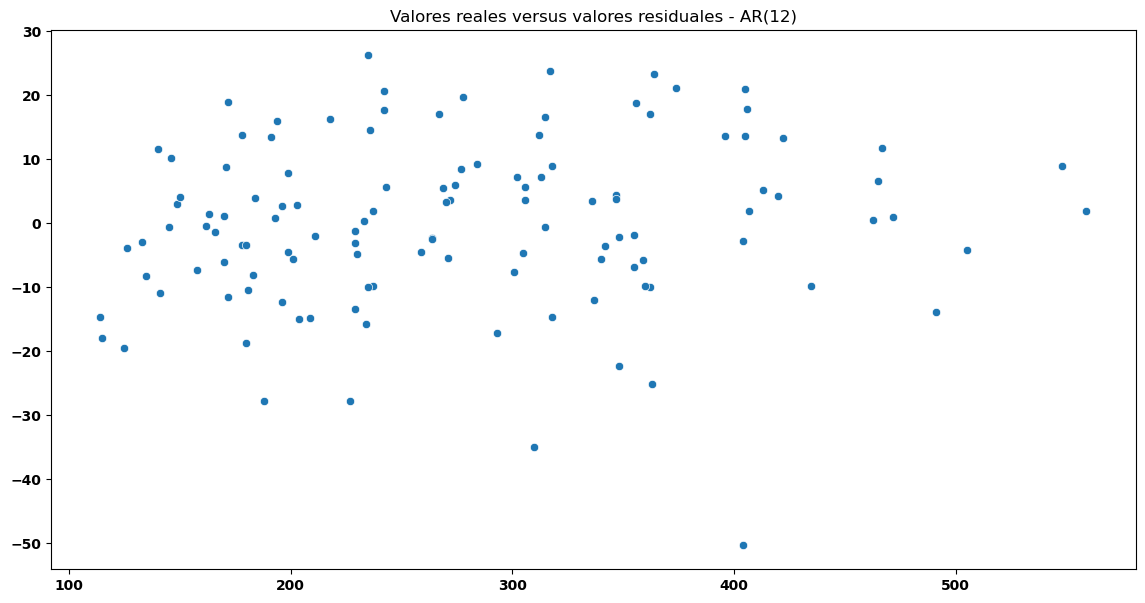

In [54]:
sns.scatterplot(x=df_train.values.flatten(), y=erorr_ar_train)
plt.title("Valores reales versus valores residuales - AR(12)")
plt.show()

In [55]:
# Coeficiente de correlación entre valores estimados y los errores
estim_ar.corr(resid_ar).round(6)

-0.0

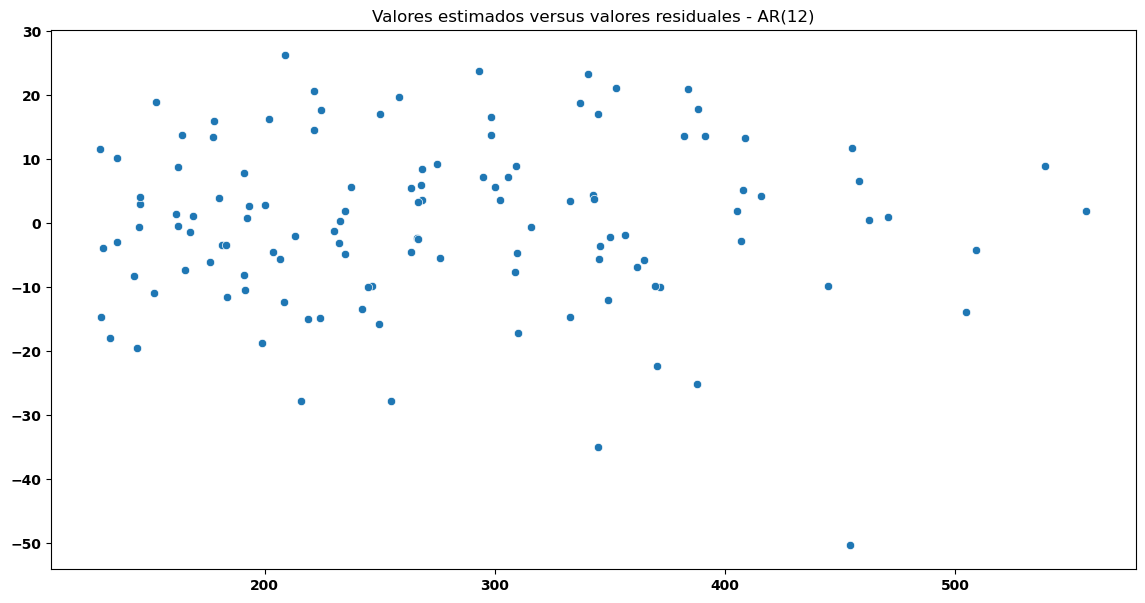

In [56]:
sns.scatterplot(x=estim_ar, y=resid_ar)
plt.title("Valores estimados versus valores residuales - AR(12)")
plt.show()

De forma resumida podemos investigar la calidad del modelo entrenado (_fitted model_) mediante varias gráficas que se pueden sacar por defecto mediante el método `plot_diagnostics()`

Estas curvas se pueden utilizar para evaluar la calidad del ajuste del modelo a los datos y para identificar cualquier problema con el modelo. Esto es lo que representa cada curva:

- **Residuos estandarizados**: esta gráfica muestra los residuos estandarizados del modelo. Si el modelo se ajusta bien a los datos, los residuos deben estar **dispersos aleatoriamente alrededor de 0**, sin ninguna desviación obvia, patrones o tendencias.

- **Gráfica de Histograma y Distribución**: Esta gráfica muestra la distribución de los residuos estandarizados. Si los residuos se distribuyen normalmente, deben **seguir una curva en forma de campana** en el histograma. El gráfico de densidad de la probabilidad muestra una versión suavizada del histograma. Si los residuos se distribuyen normalmente, la gráfica de densidad debe ser aproximadamente simétrica alrededor de 0.

- **Gráfica Q-Q normal**: esta gráfica muestra los cuantiles de los residuos estandarizados frente a los cuantiles de una distribución normal. Si los residuos se distribuyen normalmente, los puntos deben **seguir una línea recta**. Cualquier desviación de una línea recta indica la no normalidad en los residuos.

- **Correlograma**: este gráfico muestra la **autocorrelación de los residuos estandarizados** en diferentes retrasos o _lags_. Si el modelo se ajusta bien a los datos, los residuos **no deberían mostrar ninguna autocorrelación significativa** en ningún retraso.

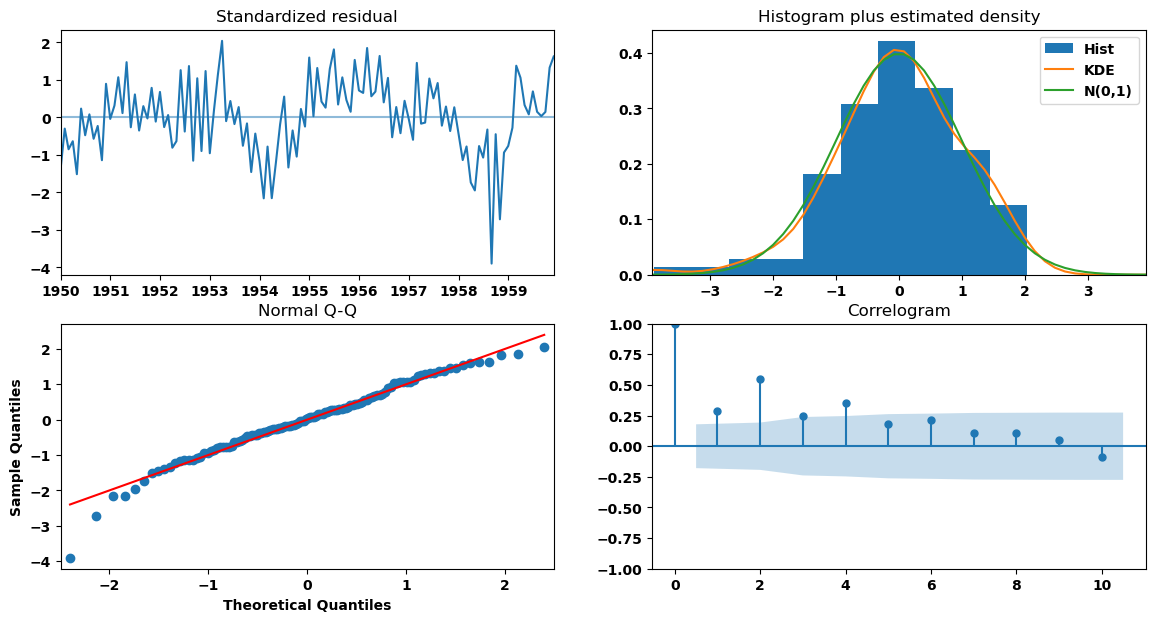

In [57]:
# Sacar las gráficas del rendimiento del modelo ajustado
fit_ar.plot_diagnostics()
plt.show()

#### Prediction evaluation (_forecasting Acuuracy_)

Después de analizar la calidad del modelo ajustado a los datos de entrenamiento, nos debemos fijar en el rendimiento del modelo **a la hora de predecir los valores no vistos** que serían las estimaciones a futuro  (***Out-of-Sample model evaluation***)

In [58]:
# Calcular las predicciones con los valores estimados por el modelo a futuro
fit_ar.predict(start=df_test.index[0],
               end=df_test.index[-1])

1960-01-01    395.343903
1960-02-01    380.991501
1960-03-01    427.292877
1960-04-01    426.434961
1960-05-01    466.115113
1960-06-01    512.094997
1960-07-01    597.533751
1960-08-01    607.171554
1960-09-01    526.982125
1960-10-01    456.079021
1960-11-01    404.152837
1960-12-01    441.644290
Freq: MS, dtype: float64

Podemos indicar el **hoizonte** de la predicción como el número de los valores a predecir por el modelo

In [59]:
pred_ar = fit_ar.forecast(steps=horizonte)
pred_ar


1960-01-01    395.343903
1960-02-01    380.991501
1960-03-01    427.292877
1960-04-01    426.434961
1960-05-01    466.115113
1960-06-01    512.094997
1960-07-01    597.533751
1960-08-01    607.171554
1960-09-01    526.982125
1960-10-01    456.079021
1960-11-01    404.152837
1960-12-01    441.644290
Freq: MS, dtype: float64

Redondeamos los valores predichos para tenerlos como número de pasajeros

In [60]:
pred_ar = pred_ar.round()
pred_ar

1960-01-01    395.0
1960-02-01    381.0
1960-03-01    427.0
1960-04-01    426.0
1960-05-01    466.0
1960-06-01    512.0
1960-07-01    598.0
1960-08-01    607.0
1960-09-01    527.0
1960-10-01    456.0
1960-11-01    404.0
1960-12-01    442.0
Freq: MS, dtype: float64

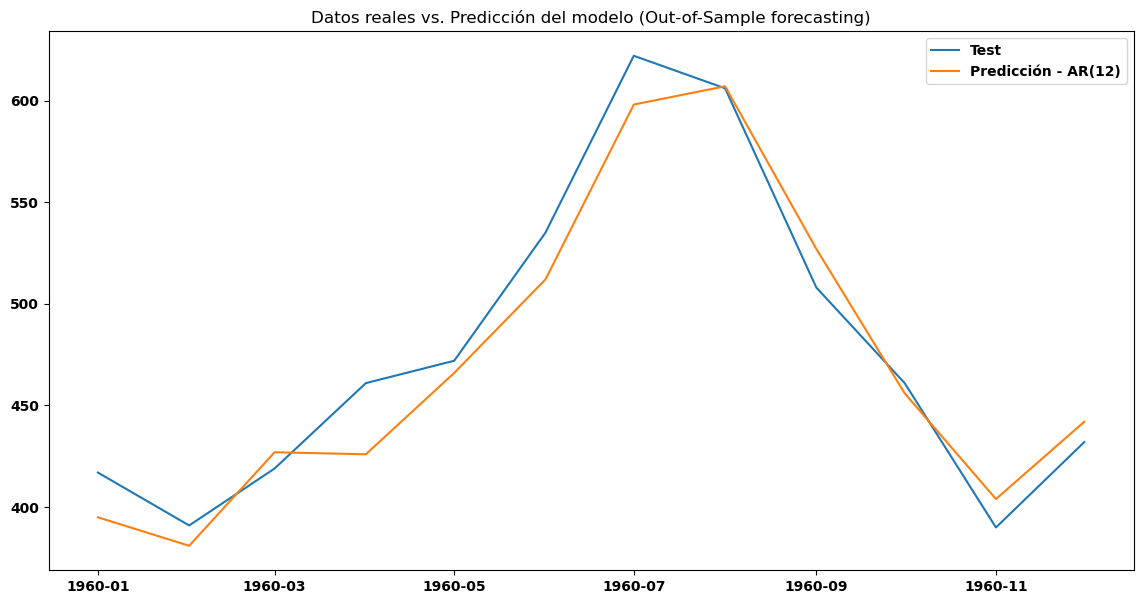

In [61]:
plt.plot(df_test, label='Test')
plt.plot(pred_ar, label='Predicción - AR(12)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

In [62]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['passengers'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['passengers'],
    name="Test",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_sn.index,
    y=pred_sn['pred'],
    name="Predicción (Seasonal Naive)",
    mode="markers+lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_ar.index,
    y=pred_ar,
    name="Predicción (AR)",
    mode="markers+lines"
    ))

fig.update_layout(title="Número de pasajeros aéreos de cada mes desde el año 1949 al 1960",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Pasajeros'
                  )

fig.show()

Se puede ver que las predicciones de este modelo, además de **seguir la forma del periodo estacional**, se adaptan a los **niveles crecientes** que son presentes en los datos reales.

In [63]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_ar))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_ar)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_ar))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_ar)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_ar))

Mean Absolute Error (MAE): 14.75
Mean Absolute Percentage Error (MAPE): 3.1381605621136095
Mean Squared Error (MSE): 308.0833333333333
Root Mean Squared Error (RMSE): 17.552302792891116
R^2 coefficient of determination: 0.9443839916558436


Como lo habíamos intuido visualmente, este modelo está generando **predicciones más precisas** que los modelos de referncia. Ahora nos fijamos en el **nivel de incertidumbre** que tenemos en los valores predichos.

#### Intervalos de confianza (___Confidence intervals___)

En la predicción de series temporales, los intervalos de predicción o intervalos de confianza nos dan una idea de **qué tan inciertos son nuestras predicciones**. Los intervalos de confianza para los valores predichos representan **un rango de valores** dentro del cual esperamos que se encuentren los valores reales con **un cierto nivel de confianza**. Un intervalo de **confianza del 95 %** significa que **hay una probabilidad del 95 % de que el valor verdadero se encuentre dentro de este intervalo**.

Usamos el método `conf_int()` sobre los datos extraídos como la predicción del modelo mediante la función `get_prediction` para el periodo en cuestión. Los intervalos por defecto marcan **un nivel de 95% de confianza** considerando `alpha=0.05` que se pueden modificar si así se desea.

In [64]:
conf_ar = fit_ar.get_prediction(start=df_test.index[0], end=df_test.index[-1]).conf_int().round()
conf_ar

lower  upper
1960-01-01  370.0  421.0
1960-02-01  352.0  410.0
1960-03-01  399.0  456.0
1960-04-01  398.0  455.0
1960-05-01  437.0  495.0
1960-06-01  483.0  541.0
1960-07-01  569.0  627.0
1960-08-01  578.0  636.0
1960-09-01  498.0  556.0
1960-10-01  427.0  485.0
1960-11-01  375.0  433.0
1960-12-01  412.0  471.0

Analizamos la evolución de los rangos que marcan los intervalos de confianza.

In [65]:
conf_ar['delta'] = conf_ar.apply(lambda x: x['upper'] - x['lower'], axis=1)
conf_ar

lower  upper  delta
1960-01-01  370.0  421.0   51.0
1960-02-01  352.0  410.0   58.0
1960-03-01  399.0  456.0   57.0
1960-04-01  398.0  455.0   57.0
1960-05-01  437.0  495.0   58.0
1960-06-01  483.0  541.0   58.0
1960-07-01  569.0  627.0   58.0
1960-08-01  578.0  636.0   58.0
1960-09-01  498.0  556.0   58.0
1960-10-01  427.0  485.0   58.0
1960-11-01  375.0  433.0   58.0
1960-12-01  412.0  471.0   59.0

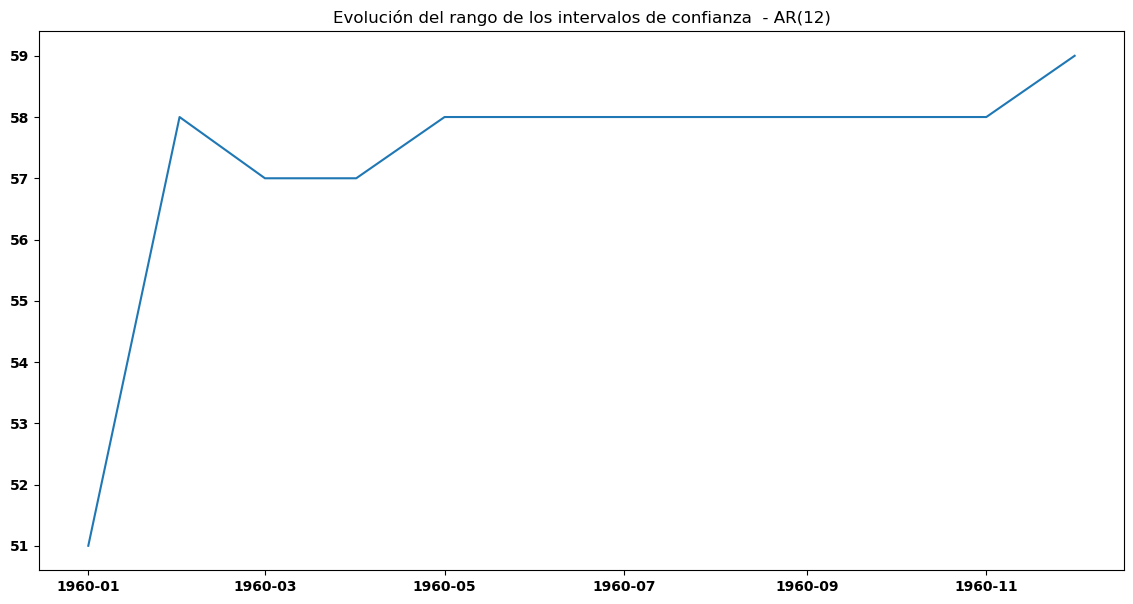

In [66]:
plt.plot(conf_ar['delta'])
plt.title("Evolución del rango de los intervalos de confianza  - AR(12)")
plt.show()

Como es de esperar, el rango de los intervalos **se aumenta con el tiempo** porque **se van acumulando los errores y los incertidumbres** presentes en las predicciones del modelo por ser de tipo `One-step-ahead forecasts`.

In [67]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['passengers'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['passengers'],
    name="Test",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_sn.index,
    y=pred_sn['pred'],
    name="Predicción (Seasonal Naive)",
    mode="markers+lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_ar.index,
    y=pred_ar,
    name="Predicción (AR)",
    mode="markers+lines"
    ))

fig.add_trace(go.Scatter(
    x=conf_ar.index,
    y=conf_ar['lower'],
    name="lower",
    mode="lines",
    line=dict(width=0),
    showlegend=False
    ))

fig.add_trace(go.Scatter(
    x=conf_ar.index,
    y=conf_ar['upper'],
    name="upper",
    mode="lines",
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty'
    ))

fig.update_layout(title="Número de pasajeros aéreos de cada mes desde el año 1949 al 1960",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Pasajeros'
                  )

fig.show()

---

### **ARIMA** (Autoregressive Integrated Moving Average)

_ARIMA_ (**promedio móvil integrado autorregresivo**) es un método estadístico ampliamente utilizado para modelar las series temporales. Los modelos ARIMA son una combinación de tres métodos separados: autoregresión (___AR___), integración (___I___) y media móvil (___MA___). El modelo ARIMA está especificado por tres parámetros ___(p, d, q)___ que determinan el número de términos autoregresivos, diferenciadores y de media móvil, respectivamente:

- **La autorregresión (AR)**: Es un método que utiliza observaciones pasadas para predecir valores futuros. El orden del modelo _AR(p)_ especifica cuántos valores pasados de la serie temporal se utilizan para predecir el valor actual.

- **La integración (I)**: Es un método que ajusta la serie temporal para hacerla estacionaria, lo que significa que sus propiedades estadísticas se mantienen constantes en el tiempo. El orden de diferenciación _(d)_ especifica el número de veces que se diferencia la serie de tiempo para hacerla estacionaria.

- **La media móvil (MA)**: Es un método que utiliza errores pasados para predecir valores futuros, por defecto para el modelo de promedio de todas las observaciones. El orden del modelo _MA(q)_ especifica cuántos errores pasados se utilizan para predecir el valor actual.

El modelo ARIMA combina estos tres métodos para crear una poderosa herramienta para el pronóstico de series de tiempo. La forma general de un modelo ARIMA es:

$ARIMA(p, d, q) = AR(p) + I(d) + MA(q)$

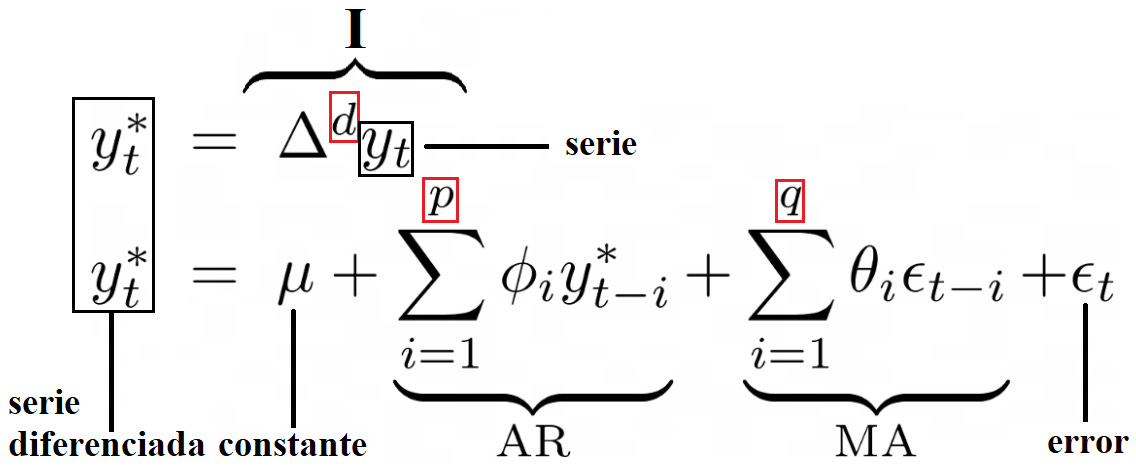

Vamos a crear un modelo ARIMA por ejemplo con la combinación de _(12,1,1)_ para añadir una diferenciación del primer orden y un componente de _Moving Average_ del mismo orden. 

In [68]:
from statsmodels.tsa.arima.model import ARIMA
modelo_arima = ARIMA(df_train, order=(12,1,1))
modelo_arima

In [69]:
# Ajustar el modelo a los datos de entrenamiento
fit_arima = modelo_arima.fit()
fit_arima


c:\Users\aleja\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\aleja\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [70]:
fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  132
Model:                ARIMA(12, 1, 1)   Log Likelihood                -499.234
Date:                Sat, 23 Mar 2024   AIC                           1026.468
Time:                        12:52:18   BIC                           1066.720
Sample:                    01-01-1949   HQIC                          1042.824
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0997      0.084      1.186      0.236      -0.065       0.264
ar.L2         -0.0921      0.066     -1.402      0.161      -0.221       0.037
ar.L3          0.0178      0.058      0.304      0.761      -0.097       0.132
ar.L4         -0.0883      0.055     -1.612      0.107      -0.196       0.019
ar.L5          0.0738      0.062      1.186      0.236      -0.048       0.196
ar.L6         -0.1154      0.060     -1.926      0.054      -0.233       0.002
ar.L7          0.0564      0.070      0.811      0.418      -0.080       0.193
ar.L8         -0.1208      0.064     -1.882      0.060      -0.246       0.005
ar.L9          0.0803      0.064      1.255      0.209      -0.045       0.206
ar.L10        -0.1263      0.064     -1.974      0.048      -0.252      -0.001
ar.L11         0.0946      0.072      1.311      0.190      -0.047       0.236
ar.L12         0.8198      0.070     11.663      0.000       0.682       0.958
ma.L1         -0.2592      0.125     -2.070      0.038      -0.505      -0.014
sigma2       102.1094     16.299      6.265      0.000      70.164     134.054
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 3.43
Prob(Q):                              0.62   Prob(JB):                         0.18
Heteroskedasticity (H):               1.98   Skew:                             0.06
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
# Consultamos los valores ajustados en el periodo de entrenamiento
estim_arima = fit_arima.fittedvalues
estim_arima

fechas
1949-01-01      0.000000
1949-02-01    112.047762
1949-03-01    120.011075
1949-04-01    136.437056
1949-05-01    124.427963
                 ...    
1959-08-01    556.230082
1959-09-01    460.569471
1959-10-01    414.165585
1959-11-01    356.410626
1959-12-01    392.434396
Freq: MS, Length: 132, dtype: float64

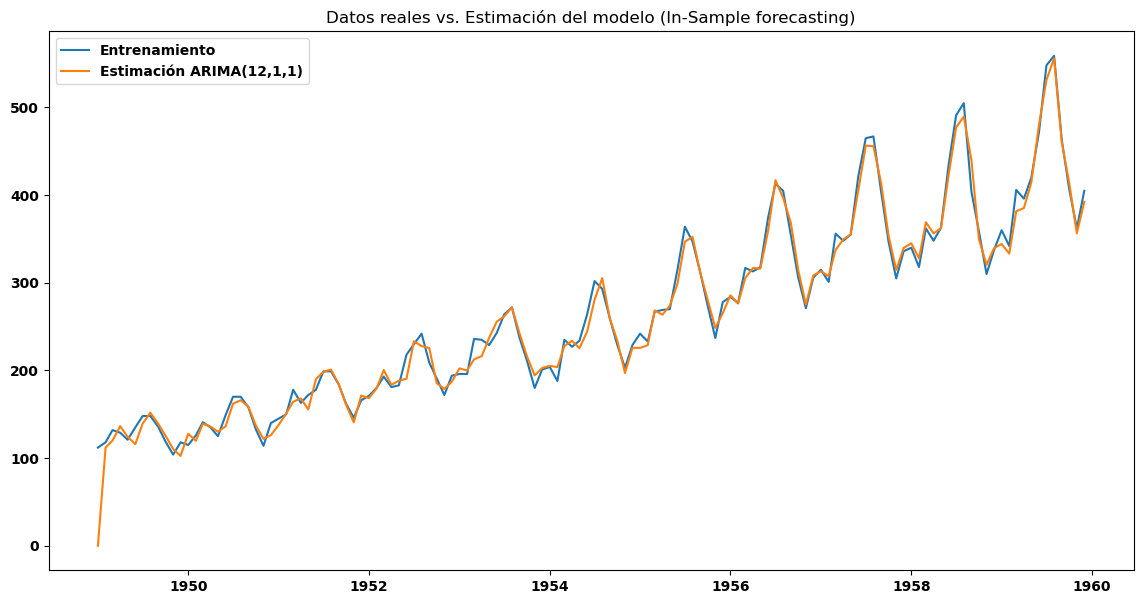

In [72]:
plt.plot(df_train, label='Entrenamiento')
plt.plot(estim_arima, label='Estimación ARIMA(12,1,1)')
plt.title("Datos reales vs. Estimación del modelo (In-Sample forecasting)")
plt.legend()
plt.show()

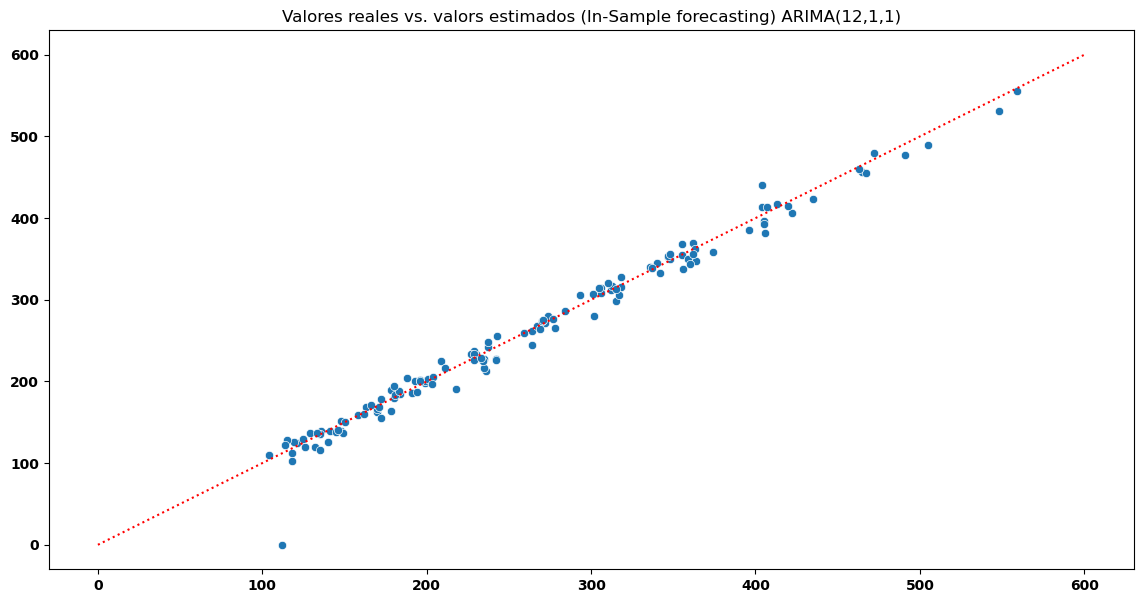

In [73]:
# Comparar los valores reales con la estimación del modelo
sns.scatterplot(x=df_train.values.flatten(), y=estim_arima)
plt.plot([0,600], [0,600], color='r', linestyle=':')
plt.title("Valores reales vs. valors estimados (In-Sample forecasting) ARIMA(12,1,1)")
plt.show()

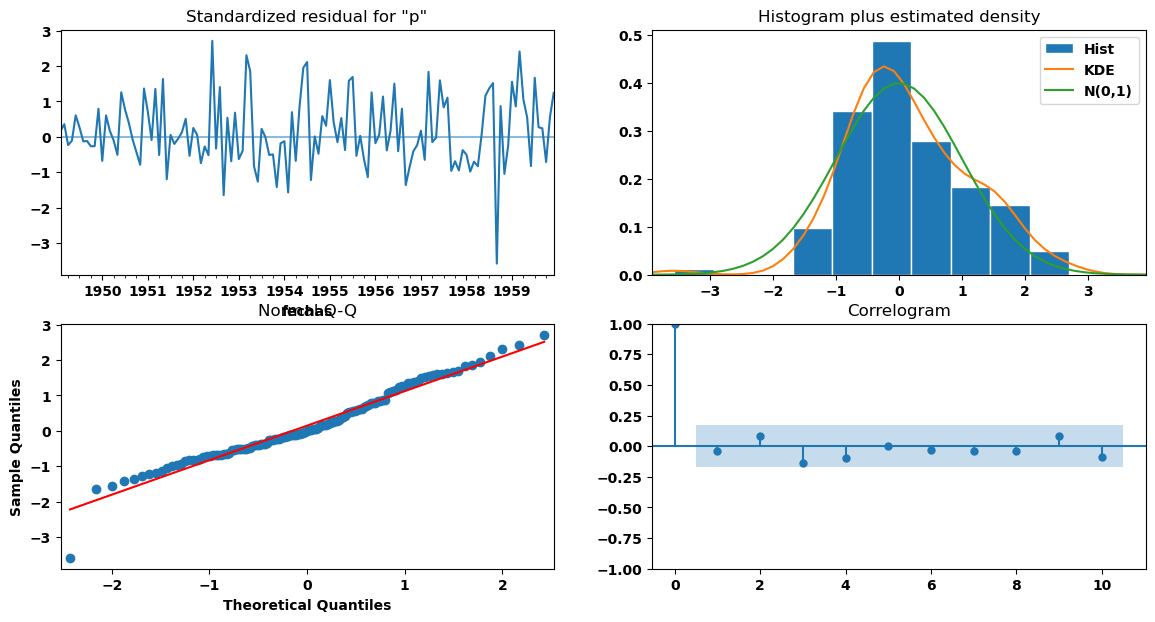

correlación entre valores reales y los errores: 0.0186
correlación entre valores estimados y los errores: -0.1122


In [74]:
# Analizamos el componente residual
# Sacar las gráficas del rendimiento del modelo ajustado
fit_arima.plot_diagnostics()
plt.show()

resid_arima = fit_arima.resid

# Coeficiente de correlación entre valores reales y los errores
print("correlación entre valores reales y los errores:", df_train['passengers'].corr(resid_arima).round(4))

# Coeficiente de correlación entre valores estimados y los errores
print("correlación entre valores estimados y los errores:", estim_arima.corr(resid_arima).round(4))

Vemos que la autocorrelación de los valores residuales no es significativo. Esto indica que el modelo ajustado tiene más calidad que el anterior.

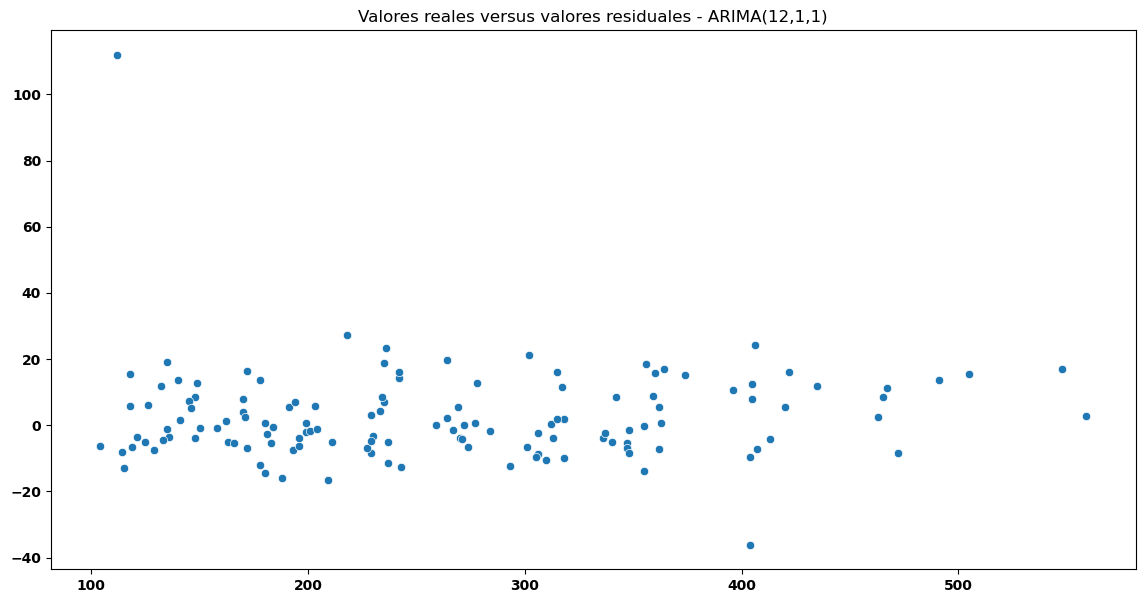

In [75]:
sns.scatterplot(x=df_train.values.flatten(), y=resid_arima)
plt.title("Valores reales versus valores residuales - ARIMA(12,1,1)")
plt.show()

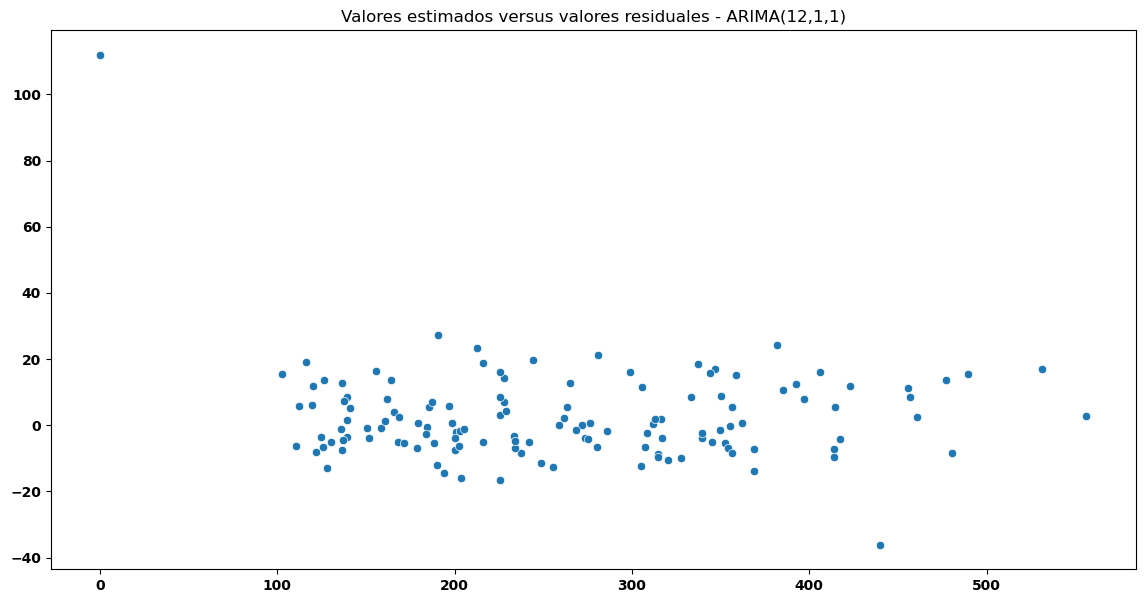

In [76]:
sns.scatterplot(x=estim_arima, y=resid_arima)
plt.title("Valores estimados versus valores residuales - ARIMA(12,1,1)")
plt.show()

In [77]:
pred_arima = fit_arima.forecast(steps=horizonte).round()
pred_arima

1960-01-01    418.0
1960-02-01    404.0
1960-03-01    457.0
1960-04-01    450.0
1960-05-01    476.0
1960-06-01    522.0
1960-07-01    596.0
1960-08-01    604.0
1960-09-01    513.0
1960-10-01    453.0
1960-11-01    407.0
1960-12-01    451.0
Freq: MS, Name: predicted_mean, dtype: float64

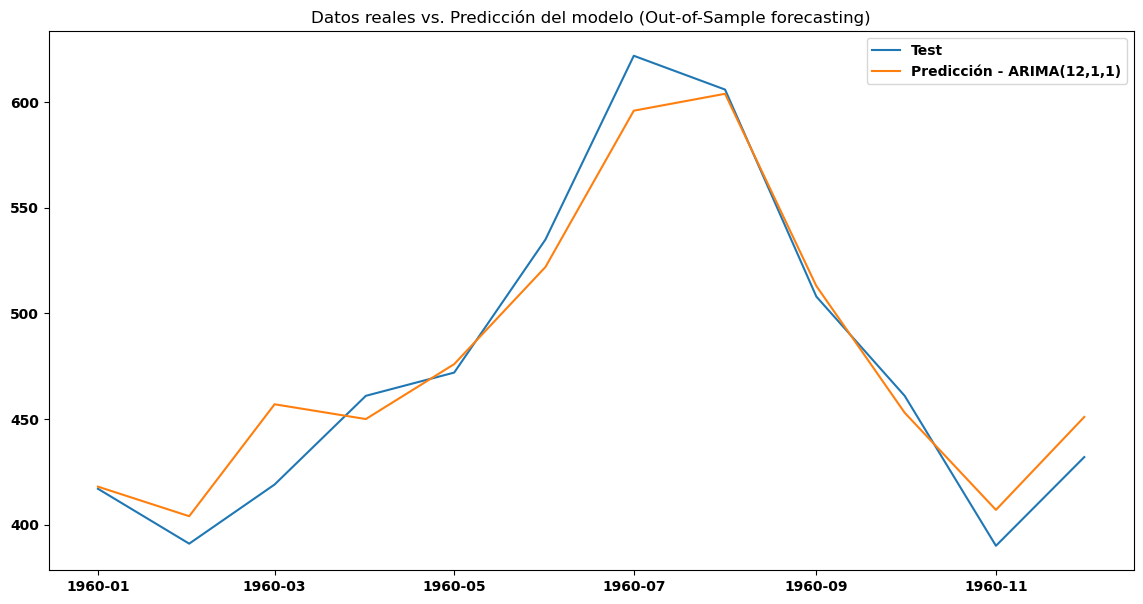

In [78]:
plt.plot(df_test, label='Test')
plt.plot(pred_arima, label='Predicción - ARIMA(12,1,1)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

In [79]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_arima))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_arima)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_arima))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_arima)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_arima))

Mean Absolute Error (MAE): 13.083333333333334
Mean Absolute Percentage Error (MAPE): 2.857011646594561
Mean Squared Error (MSE): 278.25
Root Mean Squared Error (RMSE): 16.680827317612277
R^2 coefficient of determination: 0.9497695829426189


Podemos apreciar que los resultados de este modelo **son algo mejores** que el modelo anterior de AR(12). Graficamos los valores predichos junto con los intervalos de confianza.

In [80]:
# Calcular los intervalos de confianza
conf_arima = fit_arima.get_prediction(start=df_test.index[0], end=df_test.index[-1]).conf_int().round()

# Graficar los resultados
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['passengers'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['passengers'],
    name="Test",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_ar.index,
    y=pred_ar,
    name="Predicción (AR(12))",
    mode="markers+lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_arima.index,
    y=pred_arima,
    name="Predicción (ARIMA(12,1,1))",
    mode="markers+lines"
    ))

fig.add_trace(go.Scatter(
    x=conf_arima.index,
    y=conf_arima.iloc[:,0],
    name="lower",
    mode="lines",
    line=dict(width=0),
    showlegend=False
    ))

fig.add_trace(go.Scatter(
    x=conf_arima.index,
    y=conf_arima.iloc[:,1],
    name="upper",
    mode="lines",
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty'
    ))

fig.update_layout(title="Número de pasajeros aéreos de cada mes desde el año 1949 al 1960",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Pasajeros'
                  )

fig.show()

### Seasonal ARIMA (__SARIMA__)

Los modelos ARIMA también son capaces de modelar una amplia gama de datos estacionales, considerando **un componente especialmente pensado para la estacionalidad**. 

Un modelo **ARIMA estacional** o _SARIMA_ se forma al incluir términos estacionales adicionales en los modelos ARIMA que se especifica mediante cuatro parámetros:
- El período estacional (___m___)  
- La diferencia estacional (___D___)
- El orden autoregresivo estacional (___P___)
- El orden de promedio móvil estacional (___Q___).

El modelo SARIMA se puede escribir como $SARIMA(p,d,q)(P,D,Q)_m$:

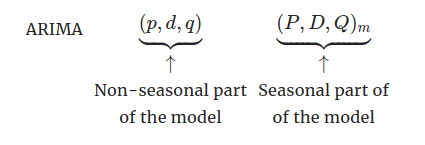

La parte estacional del modelo consta de términos que son similares a los componentes no estacionales del modelo, pero implican **desplazamientos hacia atrás del período estacional**.

Vamos a comprobar el rendimiento de un modelo como $SARIMA(1,1,1)(1,0,1)12$ usando el método `SARIMAX` de la librería _statsmodels_ 

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo = SARIMAX(df_train,
                order=(1,1,1),
                seasonal_order=(1,0,1,12))
fit_mod = modelo.fit()
print(fit_mod.summary().tables[0])
estim_mod = fit_mod.fittedvalues
pred_mod = fit_mod.forecast(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_mod))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_mod)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_mod))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_mod)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_mod))


c:\Users\aleja\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



                                     SARIMAX Results                                      
Dep. Variable:                         passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -504.962
Date:                            Sat, 23 Mar 2024   AIC                           1019.924
Time:                                    12:52:20   BIC                           1034.300
Sample:                                01-01-1949   HQIC                          1025.765
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
Mean Absolute Error (MAE): 15.916666666666666
Mean Absolute Percentage Error (MAPE): 3.292720225796942
Mean Squared Error (MSE): 367.4166666666667
Root Mean Squared Error (RMSE): 19.16811588724011
R^2 coefficient of determination: 0.9336729832866147


Como cualquier otro modelo que dispone de hiperparámetros, estos modelos se pueden ajustar para **encontrar la combinación óptima de los parámetros** del modelo.

#### Auto ARIMA

Existen diferentes métodos para encontrar los ordenes óptimos de los modelos de ARIMA. Una herramienta común para automatizar esta búsqueda es el método `auto_arima` de la librería ___pmdarima___.

`pmdarima` es paquete de Python que se basa en las bibliotecas _statsmodels_ y _scikit-learn_ y proporciona una interfaz conveniente para la selección de modelos, el ajuste de hiperparámetros y la evaluación de modelos de series temporales.

In [82]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [83]:
from pmdarima.arima import auto_arima

fit_arima_auto = auto_arima(df_train,
                            start_p=1,
                            start_q=0,
                            max_p=20,
                            max_q=10,
                            seasonal=False,
                            stepwise=True)

In [84]:
fit_arima_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -603.341
Date:                Sat, 23 Mar 2024   AIC                           1218.683
Time:                        12:52:30   BIC                           1235.934
Sample:                    01-01-1949   HQIC                          1225.692
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7157      0.212      3.379      0.001       0.301       1.131
ar.L1          1.6431      0.028     57.904      0.000       1.587       1.699
ar.L2         -0.9129      0.027    -33.338      0.000      -0.967      -0.859
ma.L1         -1.8478      0.036    -51.463      0.000      -1.918      -1.777
ma.L2          0.9466      0.038     24.988      0.000       0.872       1.021
sigma2       564.8460     67.205      8.405      0.000     433.126     696.566
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.36   Prob(JB):                         0.39
Heteroskedasticity (H):               6.40   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
fit_arima_auto.fittedvalues()

fechas
1949-01-01      2.652215
1949-02-01    114.677235
1949-03-01    121.440910
1949-04-01    137.297870
1949-05-01    129.838195
                 ...    
1959-08-01    515.367639
1959-09-01    502.441020
1959-10-01    410.114979
1959-11-01    371.769103
1959-12-01    355.003904
Freq: MS, Length: 132, dtype: float64

Podemos usar el método `.predict_in_sample()` para sacar las estimaciones del modelo: 

In [86]:
fit_arima_auto.predict_in_sample()

fechas
1949-01-01      2.652215
1949-02-01    114.677235
1949-03-01    121.440910
1949-04-01    137.297870
1949-05-01    129.838195
                 ...    
1959-08-01    515.367639
1959-09-01    502.441020
1959-10-01    410.114979
1959-11-01    371.769103
1959-12-01    355.003904
Freq: MS, Name: predicted_mean, Length: 132, dtype: float64

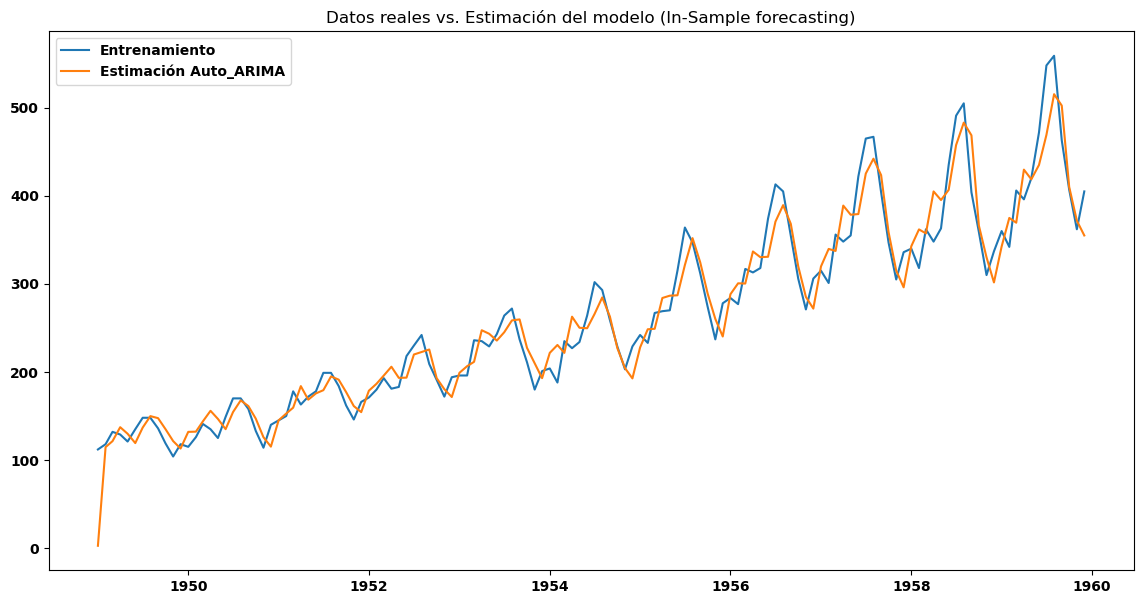

In [87]:
estim_arima_auto = fit_arima_auto.fittedvalues()
plt.plot(df_train, label='Entrenamiento')
plt.plot(estim_arima_auto, label='Estimación Auto_ARIMA')
plt.title("Datos reales vs. Estimación del modelo (In-Sample forecasting)")
plt.legend()
plt.show()

In [88]:
pred_arima_auto = fit_arima_auto.predict(horizonte).round()
pred_arima_auto

1960-01-01    416.0
1960-02-01    442.0
1960-03-01    477.0
1960-04-01    510.0
1960-05-01    534.0
1960-06-01    543.0
1960-07-01    537.0
1960-08-01    521.0
1960-09-01    499.0
1960-10-01    479.0
1960-11-01    467.0
1960-12-01    466.0
Freq: MS, dtype: float64

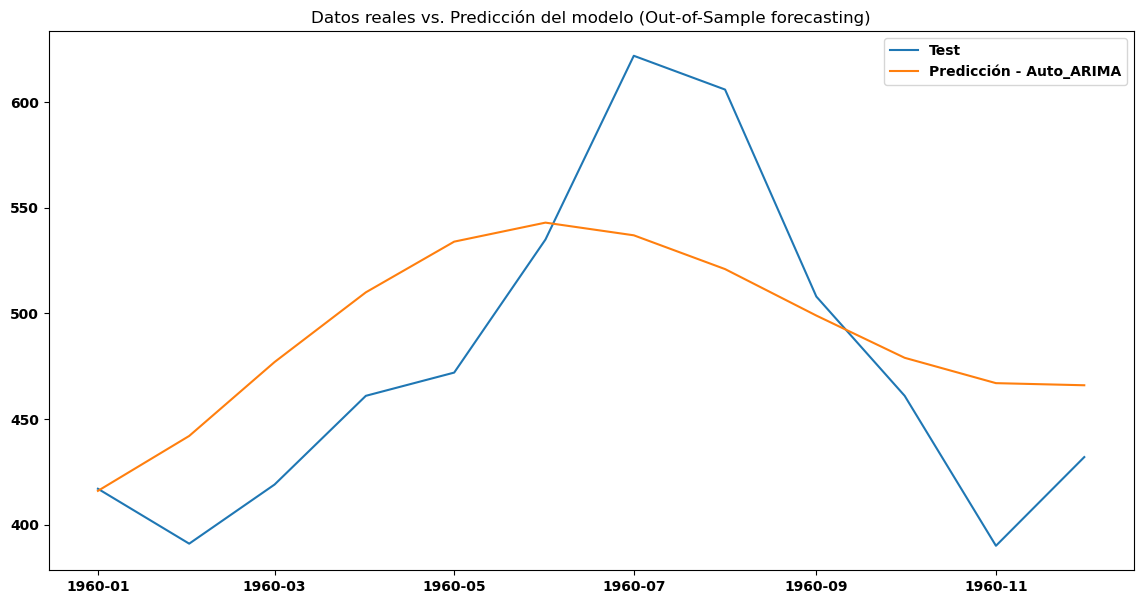

In [89]:
plt.plot(df_test, label='Test')
plt.plot(pred_arima_auto, label='Predicción - Auto_ARIMA')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

In [90]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_arima_auto))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_arima_auto)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_arima_auto))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_arima_auto)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_arima_auto))

Mean Absolute Error (MAE): 44.75
Mean Absolute Percentage Error (MAPE): 9.447326879184816
Mean Squared Error (MSE): 2851.25
Root Mean Squared Error (RMSE): 53.3970972993851
R^2 coefficient of determination: 0.4852848997848772


Vemos que esta búsqueda no nos lleva necesariamente a conseguir un modelo mejor que los anteriores. Probamos con los modelos tipo _SARIMA_ al incluir el componente estacional. 

In [91]:
from pmdarima.arima import auto_arima

fit_sarima_auto = auto_arima(df_train,
                             start_p=1,
                             start_q=1,
                             start_P=1,
                             D=1,
                             d=None,
                             m=12,
                             seasonal=True,
                             stepwise=True)

In [92]:
fit_sarima_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Sat, 23 Mar 2024   AIC                            905.686
Time:                                    12:52:42   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
fit_sarima_auto.predict_in_sample()

fechas
1949-01-01     30.552454
1949-02-01     30.572951
1949-03-01     30.592460
1949-04-01     30.611639
1949-05-01     30.626824
                 ...    
1959-08-01    552.061010
1959-09-01    456.963719
1959-10-01    411.846959
1959-11-01    356.810600
1959-12-01    383.081292
Freq: MS, Name: predicted_mean, Length: 132, dtype: float64

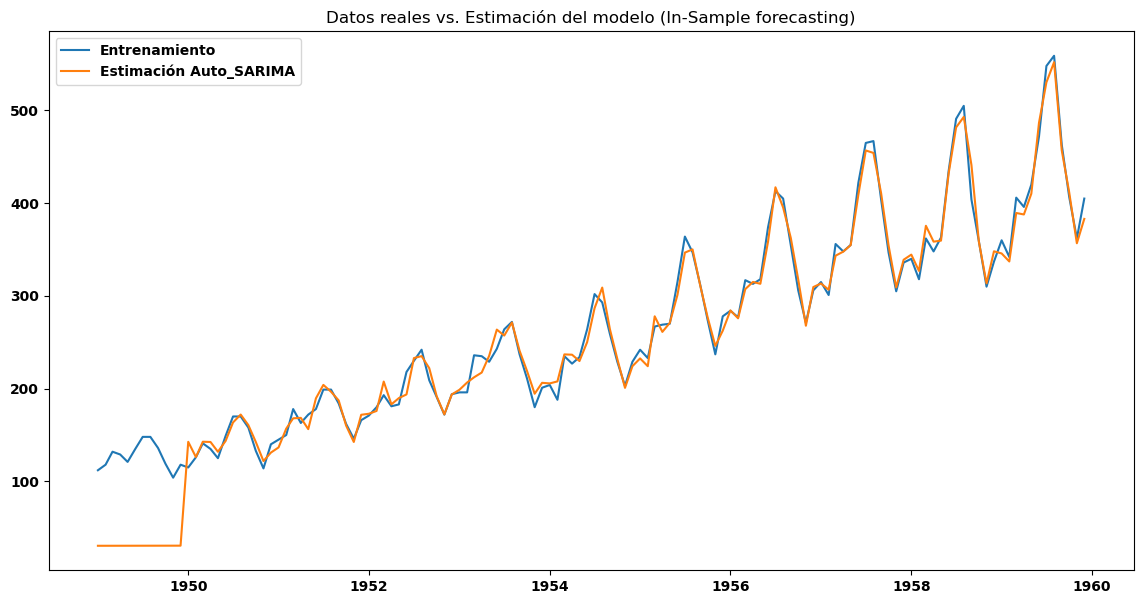

In [94]:
estim_sarima_auto = fit_sarima_auto.predict_in_sample()
plt.plot(df_train, label='Entrenamiento')
plt.plot(estim_sarima_auto, label='Estimación Auto_SARIMA')
plt.title("Datos reales vs. Estimación del modelo (In-Sample forecasting)")
plt.legend()
plt.show()

In [95]:
pred_sarima_auto = fit_sarima_auto.predict(horizonte).round()
pred_sarima_auto

1960-01-01    420.0
1960-02-01    400.0
1960-03-01    458.0
1960-04-01    444.0
1960-05-01    465.0
1960-06-01    514.0
1960-07-01    588.0
1960-08-01    597.0
1960-09-01    500.0
1960-10-01    442.0
1960-11-01    396.0
1960-12-01    439.0
Freq: MS, dtype: float64

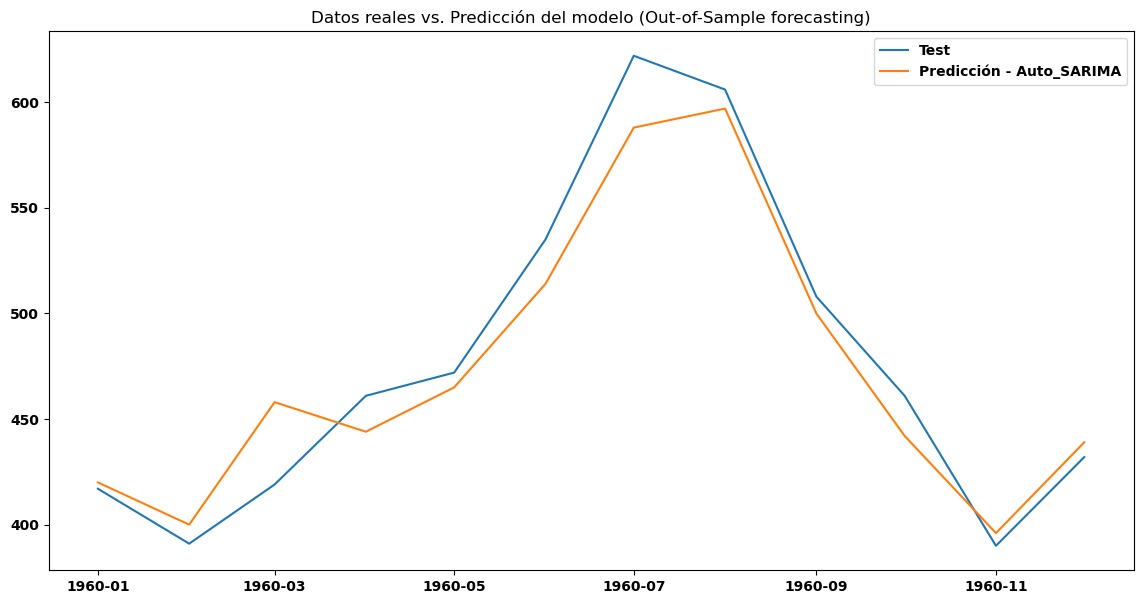

In [96]:
plt.plot(df_test, label='Test')
plt.plot(pred_sarima_auto, label='Predicción - Auto_SARIMA')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

In [97]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_sarima_auto))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_sarima_auto)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_sarima_auto))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_sarima_auto)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_sarima_auto))

Mean Absolute Error (MAE): 14.916666666666666
Mean Absolute Percentage Error (MAPE): 3.1026256061288504
Mean Squared Error (MSE): 344.75
Root Mean Squared Error (RMSE): 18.567444627627143
R^2 coefficient of determination: 0.9377648291804774


Este modelo tiene un mejor rendimiento al tener incluido el componente estacional. A pesar de que este método tiene una búsqueda tipo `GridSearch` integrado, siempre se pueden implementar técnicas propias para encontrar el modelo más óptimo.   

Probamos por ejemplo con la combinación $SARIMA(2,0,0)(7,0,1)12$

In [98]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo = SARIMAX(df_train,
                order=(2,0,0),
                seasonal_order=(7,0,1,12))
fit_mod = modelo.fit()
print(fit_mod.summary().tables[0])
estim_mod = fit_mod.fittedvalues
pred_mod = fit_mod.forecast(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_mod))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_mod)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_mod))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_mod)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_mod))


c:\Users\aleja\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



c:\Users\aleja\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                           passengers   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(7, 0, [1], 12)   Log Likelihood                -507.500
Date:                              Sat, 23 Mar 2024   AIC                           1037.000
Time:                                      12:52:59   BIC                           1068.711
Sample:                                  01-01-1949   HQIC                          1049.886
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
Mean Absolute Error (MAE): 12.083333333333334
Mean Absolute Percentage Error (MAPE): 2.668800279838075
Mean Squared Error (MSE): 231.75
Root Mean Squared Error (RMSE): 15.22333734763833
R^2 coefficient of determination: 0.9581638844454696


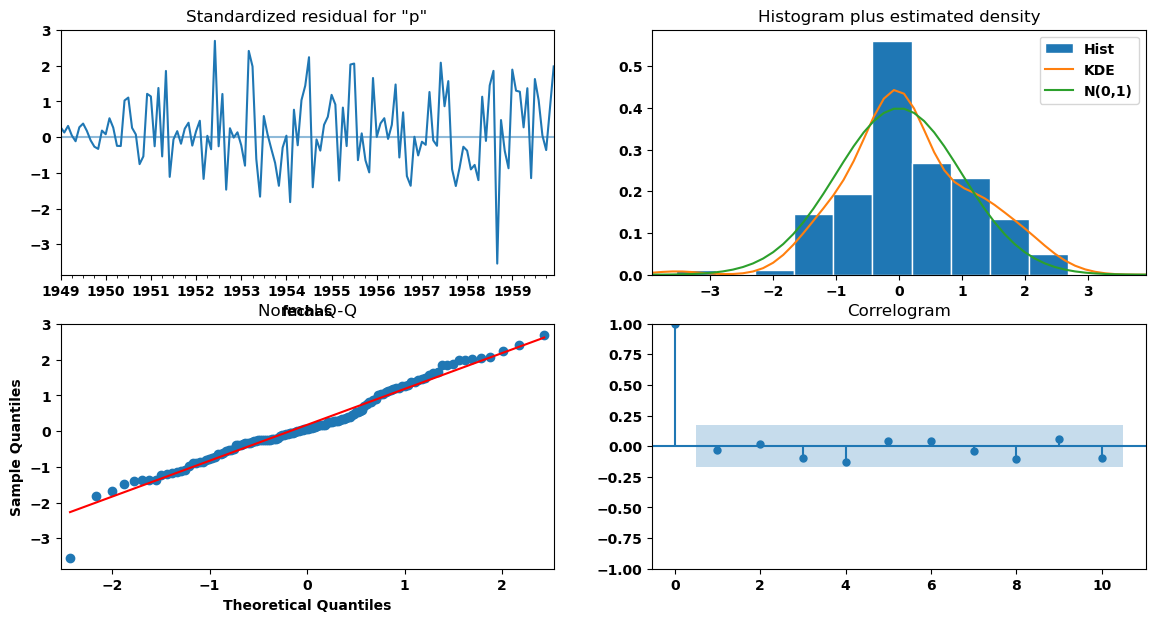

correlación entre valores reales y los errores: -0.0073
correlación entre valores estimados y los errores: -0.1349


In [99]:
# Analizamos el componente residual
# Sacar las gráficas del rendimiento del modelo ajustado
fit_mod.plot_diagnostics()
plt.show()

resid_sarima = fit_mod.resid

# Coeficiente de correlación entre valores reales y los errores
print("correlación entre valores reales y los errores:", df_train['passengers'].corr(resid_sarima).round(4))

# Coeficiente de correlación entre valores estimados y los errores
print("correlación entre valores estimados y los errores:", estim_mod.corr(resid_sarima).round(4))

---

### Exponential Smoothing

El suavizado exponencial (___Exponential Smoothing___) es un método para modelar las series de tiempo que se basa en la idea de que **el valor futuro de una serie de tiempo es un promedio ponderado de sus valores pasados**, donde las **observaciones más recientes reciben pesos más altos** que las observaciones más antiguas. El método se llama "`exponencial`" porque **los pesos disminuyen exponencialmente** a medida que las observaciones envejecen y se alejan del momento actual.

Este método es lo suficientemente flexible para **manejar diferentes tipos de patrones** en series temporales, como tendencias, estacionalidad e incluso las fluctuaciones irregulares.

Hay distintas variaciones de *suavizado exponencial*, cada una de las cuales hace suposiciones diferentes sobre los datos. Las variantes más utilizadas son:

- ***Simple Exponential Smoothing***: Este método asume que la serie de tiempo **no tiene tendencia ni estacionalidad**, y el pronóstico para el próximo valor se basa únicamente en el promedio ponderado de las observaciones anteriores.

- ***Holt's Linear Exponential Smoothing***: Este método asume que la serie de tiempo **tiene una tendencia lineal** pero no estacionalidad.

- ***Holt-Winters Exponential Smoothing***: Este método asume que la serie de tiempo **tiene una tendencia lineal** y **un componente estacional**, y el valor para el próximo paso se basa en un promedio ponderado de observaciones pasadas, un componente de tendencia y un componente estacional.

El suavizado exponencial es un método ampliamente utilizado por su simplicidad, **flexibilidad** y capacidad para capturar diferentes tipos de patrones en series temporales. Sin embargo, tiene algunas limitaciones, como su **incapacidad para manejar patrones muy complejos** y el hecho de que asume que los valores futuros de la serie dependen únicamente de sus valores pasados.

In [100]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

modelo_exp = ExponentialSmoothing(df_train,
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=12)

fit_exp = modelo_exp.fit()
fit_exp.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:               passengers   No. Observations:                  132
Model:             ExponentialSmoothing   SSE                          17837.581
Optimized:                         True   AIC                            679.626
Trend:                         Additive   BIC                            725.751
Seasonal:                      Additive   AICC                           685.680
Seasonal Periods:                    12   Date:                 Sat, 23 Mar 2024
Box-Cox:                          False   Time:                         12:53:00
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2511477                alpha                 True
smoothing_trend              2.4206e-10                 beta                 True
smoothing_seasonal            0.7488523                gamma                 True
initial_level                 118.52488                  l.0                 True
initial_trend                 2.5576494                  b.0                 True
initial_seasons.0            -9.0824867                  s.0                 True
initial_seasons.1            -3.5072344                  s.1                 True
initial_seasons.2             8.9876993                  s.2                 True
initial_seasons.3             3.7794698                  s.3                 True
initial_seasons.4            -4.9430874                  s.4                 True
initial_seasons.5             9.1747939                  s.5                 True
initial_seasons.6             21.374583                  s.6                 True
initial_seasons.7             18.913054                  s.7                 True
initial_seasons.8             4.6980415                  s.8                 True
initial_seasons.9            -14.233866                  s.9                 True
initial_seasons.10           -28.855454                 s.10                 True
initial_seasons.11           -12.470333                 s.11                 True
---------------------------------------------------------------------------------
"""

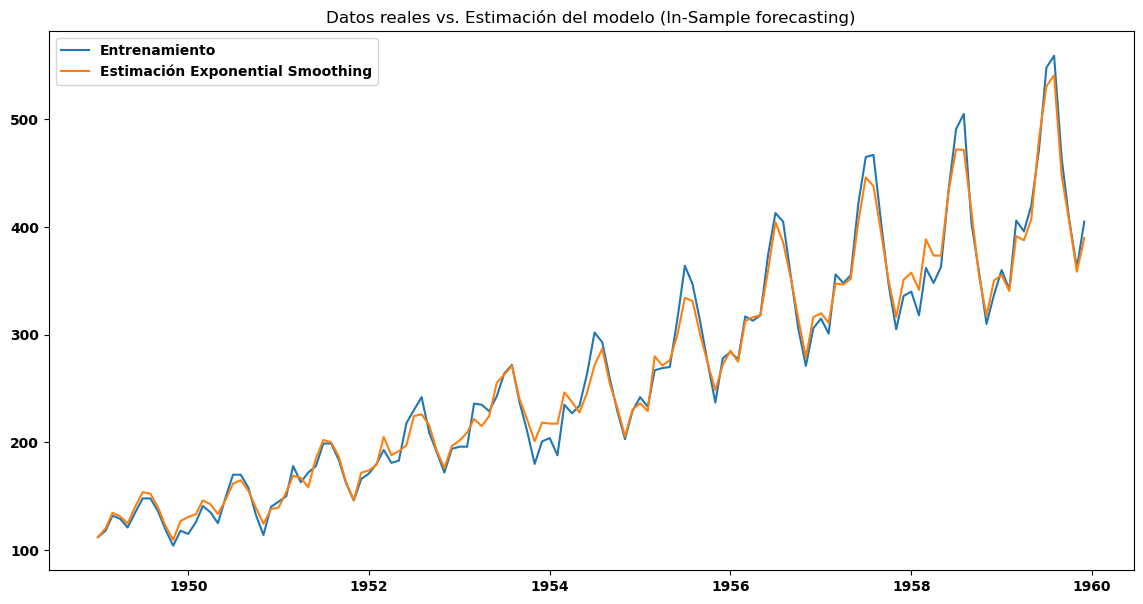

In [101]:
estim_exp = fit_exp.fittedvalues
plt.plot(df_train, label='Entrenamiento')
plt.plot(estim_exp, label='Estimación Exponential Smoothing')
plt.title("Datos reales vs. Estimación del modelo (In-Sample forecasting)")
plt.legend()
plt.show()

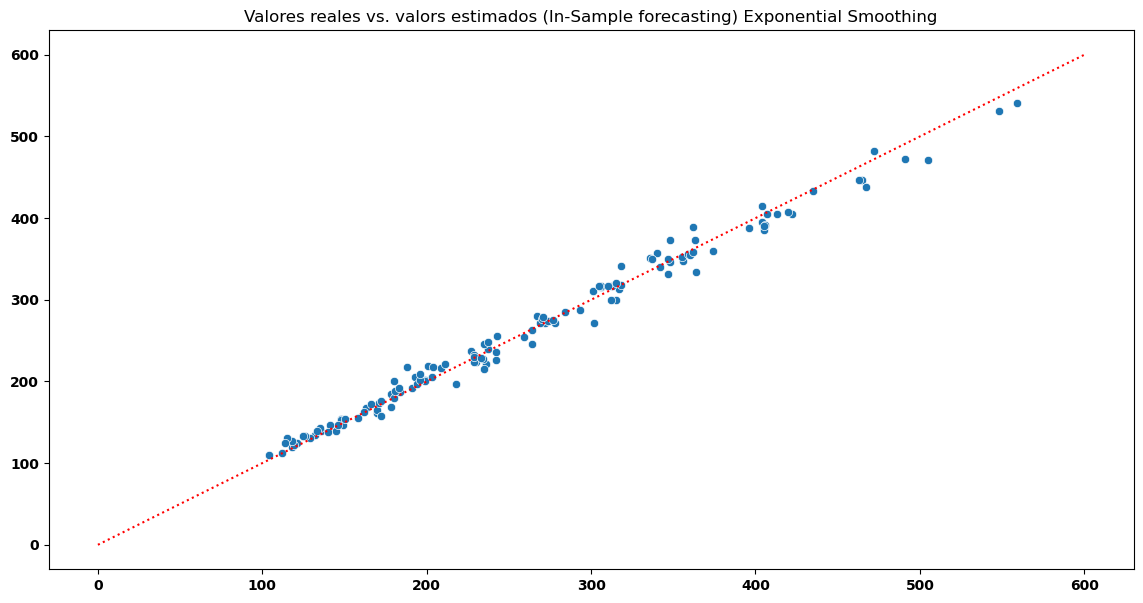

In [102]:
# Comparar los valores reales con la estimación del modelo
sns.scatterplot(x=df_train.values.flatten(), y=estim_exp)
plt.plot([0,600], [0,600], color='r', linestyle=':')
plt.title("Valores reales vs. valors estimados (In-Sample forecasting) Exponential Smoothing")
plt.show()

In [103]:
# Analizamos el componente residual
resid_exp = fit_exp.resid
resid_exp.describe()


count    132.000000
mean       0.000089
std       11.668965
min      -29.336398
25%       -7.328519
50%       -1.772065
75%        5.724545
max       33.415786
dtype: float64

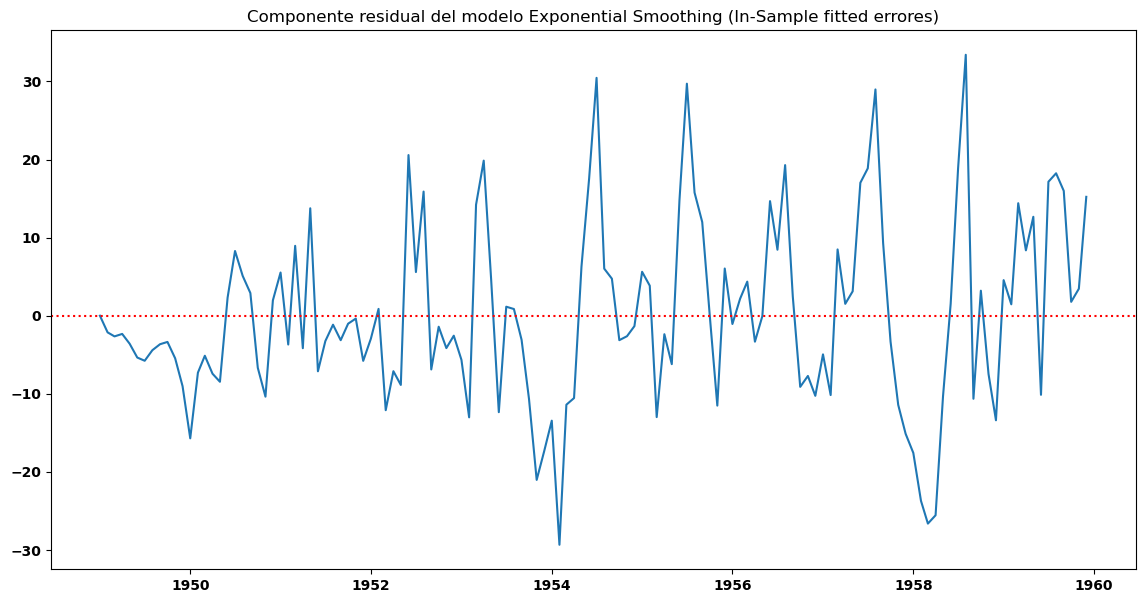

In [104]:
plt.plot(resid_exp)
plt.title("Componente residual del modelo Exponential Smoothing (In-Sample fitted errores)")
plt.axhline(y=0, color='r', linestyle=':')
plt.show()

c:\Users\aleja\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



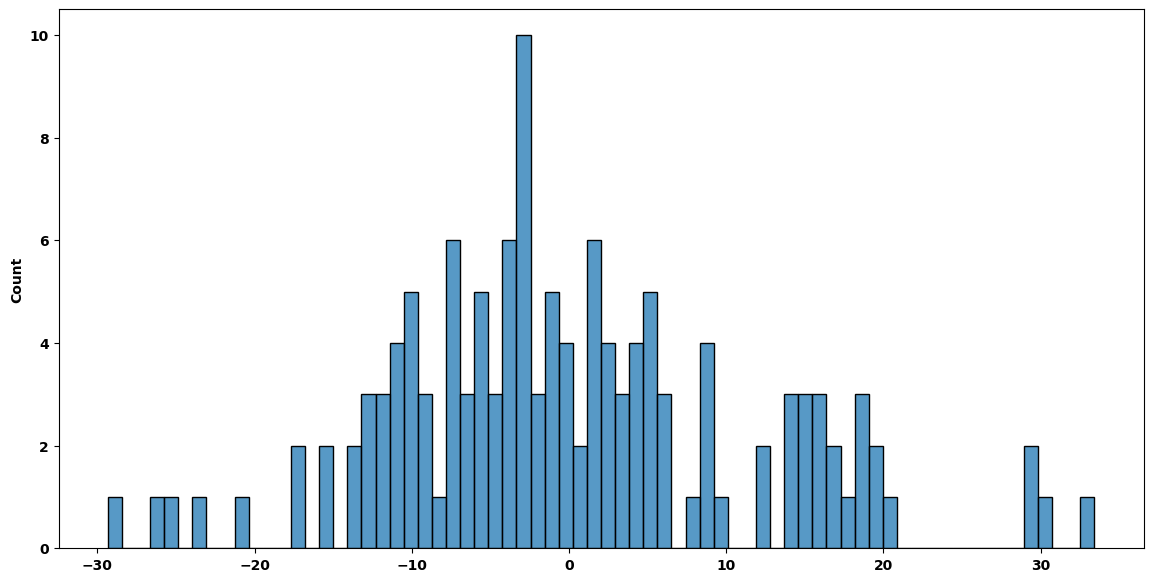

In [105]:
# El histograma del componente residual (in-sample-errors)
sns.histplot(data=resid_exp, bins=70)
plt.show()

c:\Users\aleja\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



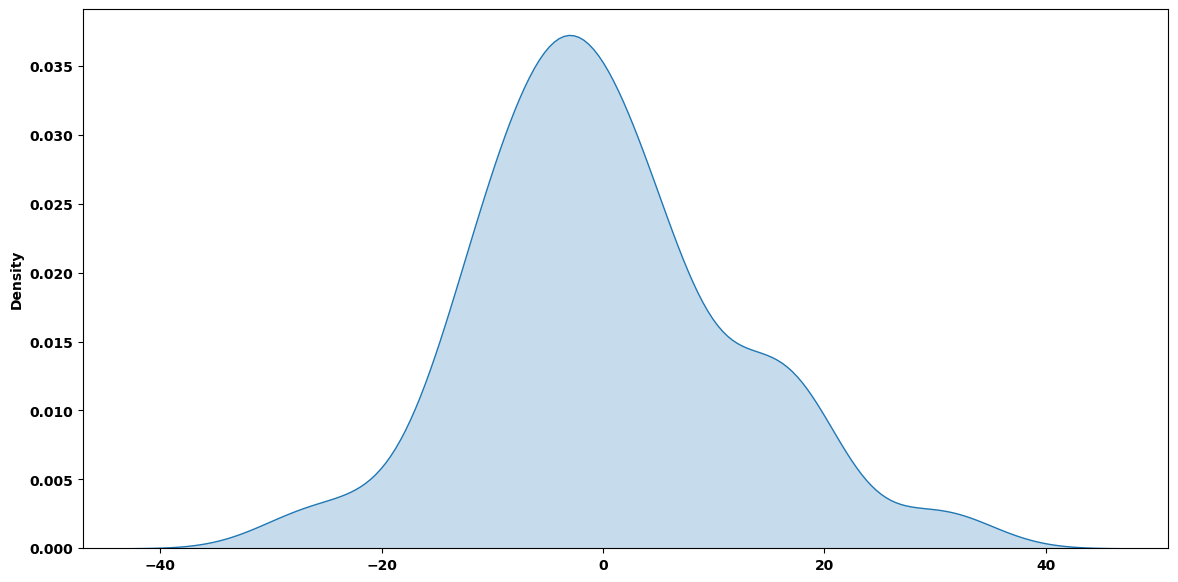

In [106]:
# La dsitribución del componente residual (in-sample-errors)
sns.kdeplot(data=resid_exp, fill=True)
plt.show()

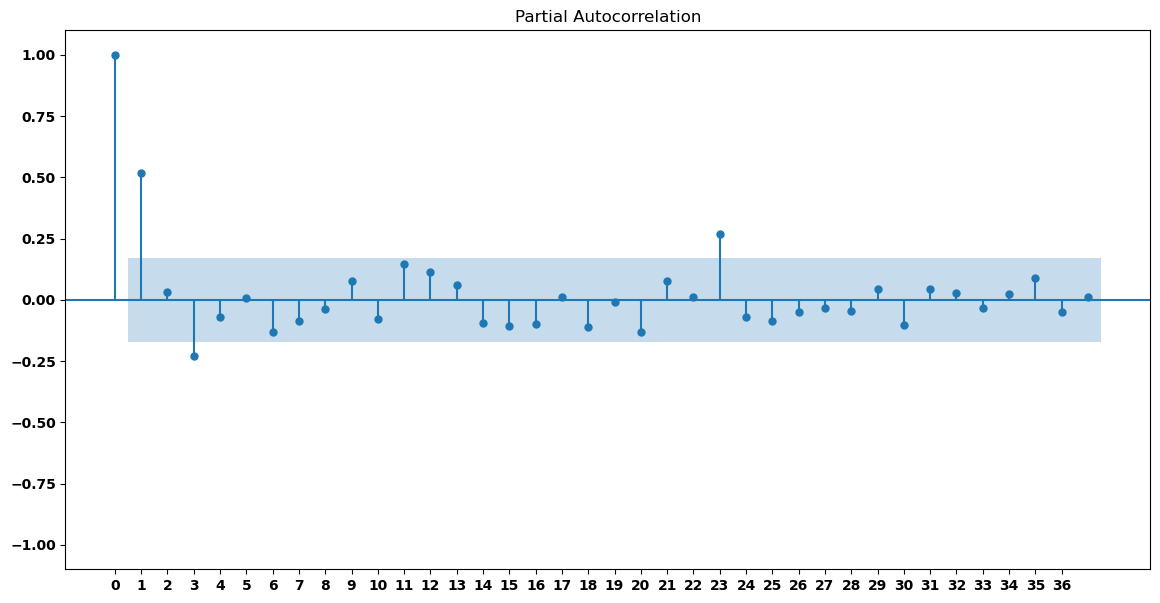

In [107]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(resid_exp, lags=37, method='ywm')
plt.xticks(np.arange(37))
plt.ylim(-1.1,1.1)
plt.show()

0.4206


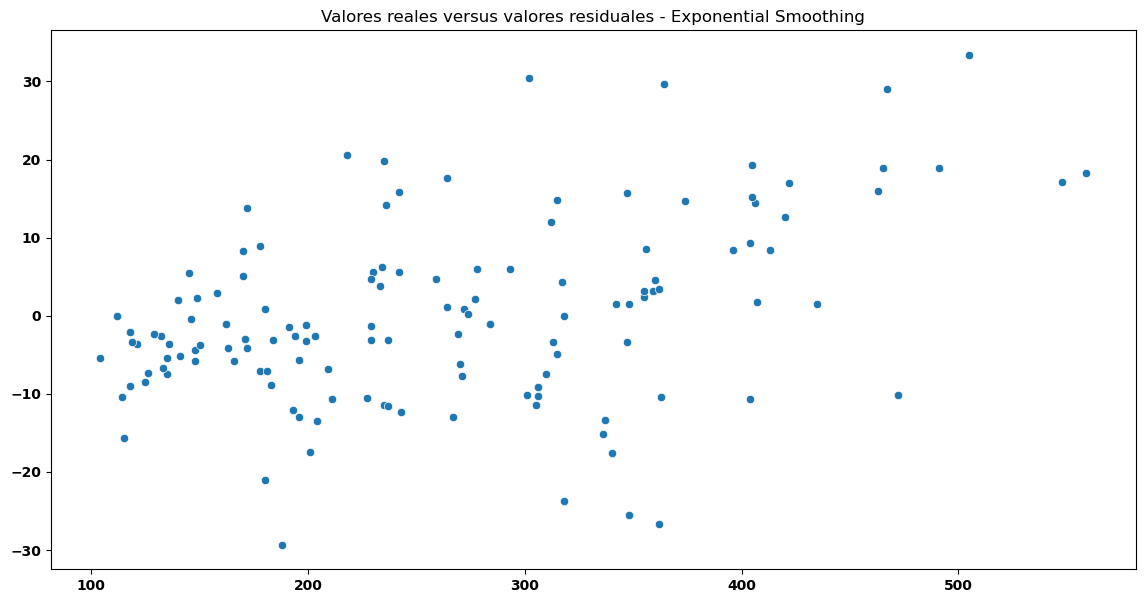

In [108]:
# Coeficiente de correlación entre valores reales y los errores
print(df_train['passengers'].corr(resid_exp).round(4))

sns.scatterplot(x=df_train.values.flatten(), y=resid_exp)
plt.title("Valores reales versus valores residuales - Exponential Smoothing")
plt.show()

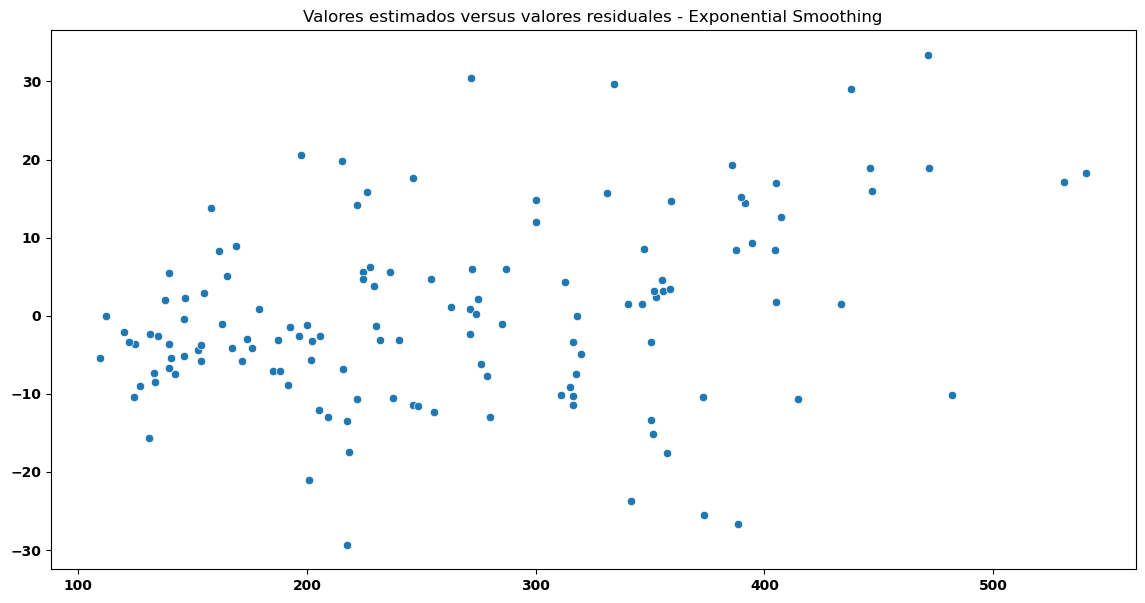

0.3244


In [109]:
sns.scatterplot(x=estim_exp, y=resid_exp)
plt.title("Valores estimados versus valores residuales - Exponential Smoothing")
plt.show()

# Coeficiente de correlación entre valores estimados y los errores
print(estim_exp.corr(resid_exp).round(4))

In [110]:
# Sacamos las predicciones del modelo Exponential Smoothing
pred_exp = fit_exp.forecast(steps=horizonte).round()
pred_exp

1960-01-01    415.0
1960-02-01    397.0
1960-03-01    457.0
1960-04-01    445.0
1960-05-01    466.0
1960-06-01    521.0
1960-07-01    592.0
1960-08-01    599.0
1960-09-01    499.0
1960-10-01    442.0
1960-11-01    397.0
1960-12-01    424.0
Freq: MS, dtype: float64

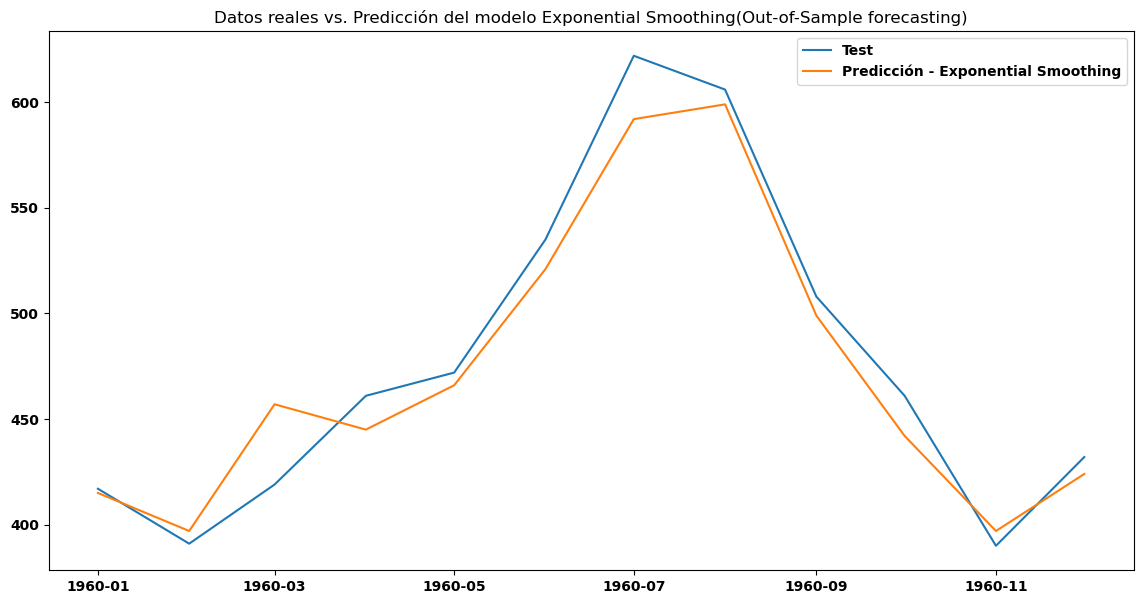

In [111]:
plt.plot(df_test, label='Test')
plt.plot(pred_exp, label='Predicción - Exponential Smoothing')
plt.title("Datos reales vs. Predicción del modelo Exponential Smoothing(Out-of-Sample forecasting)")
plt.legend()
plt.show()

In [112]:
# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_exp))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test, pred_exp)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_exp))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_exp)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_exp))

Mean Absolute Error (MAE): 13.5
Mean Absolute Percentage Error (MAPE): 2.8300165965512365
Mean Squared Error (MSE): 289.6666666666667
Root Mean Squared Error (RMSE): 17.01959654829299
R^2 coefficient of determination: 0.9477086164446071


Vemos que la precisión de **los valores predichos parecen muy aceptable**, aunque posiblemente queda **información no extraída** por el modelo que hace que haya algo de **correlación** entre valores residuales y los valores reales o estimados por el modelo, además por la **autocorrelación** entre esos errores. 

---

### **`Ejercicio 26.1`**

Vamos a nalizar los datos de **`Sunspots Dataset`** que son números promediados mensuales de **manchas solares desde 1749 hasta 1983**. Esta serie temporal se ha recolectado en el _Observatorio Federal Suizo_ (_**Zúrich**_) hasta **1960**, luego en el _Observatorio Astronómico de Japón_ (**_Tokio_**).  

Los números de manchas solares son una *medida de la actividad solar*. Los datos vienen en las unidades originales utilizadas por los observadores de forma bruta y **no hay ajustes** por cambios en la instrumentación o sesgo del observador.

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
df_spot = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', index_col=False)
df_spot


Month  Sunspots
0     1749-01      58.0
1     1749-02      62.6
2     1749-03      70.0
3     1749-04      55.7
4     1749-05      85.0
...       ...       ...
2815  1983-08      71.8
2816  1983-09      50.3
2817  1983-10      55.8
2818  1983-11      33.3
2819  1983-12      33.4

[2820 rows x 2 columns]

In [114]:
# Convertir la columna en fechas tipo DatetimeIndex
df_spot['fechas'] = pd.to_datetime(df_spot['Month'], format='%Y-%m')

# Convertir la columna de fechas a los índices del DataFrame
df_spot.set_index('fechas', inplace=True)

# Quitar las columnas que ya no se usan
df_spot.drop(columns='Month', inplace=True)

df_spot

Sunspots
fechas              
1749-01-01      58.0
1749-02-01      62.6
1749-03-01      70.0
1749-04-01      55.7
1749-05-01      85.0
...              ...
1983-08-01      71.8
1983-09-01      50.3
1983-10-01      55.8
1983-11-01      33.3
1983-12-01      33.4

[2820 rows x 1 columns]

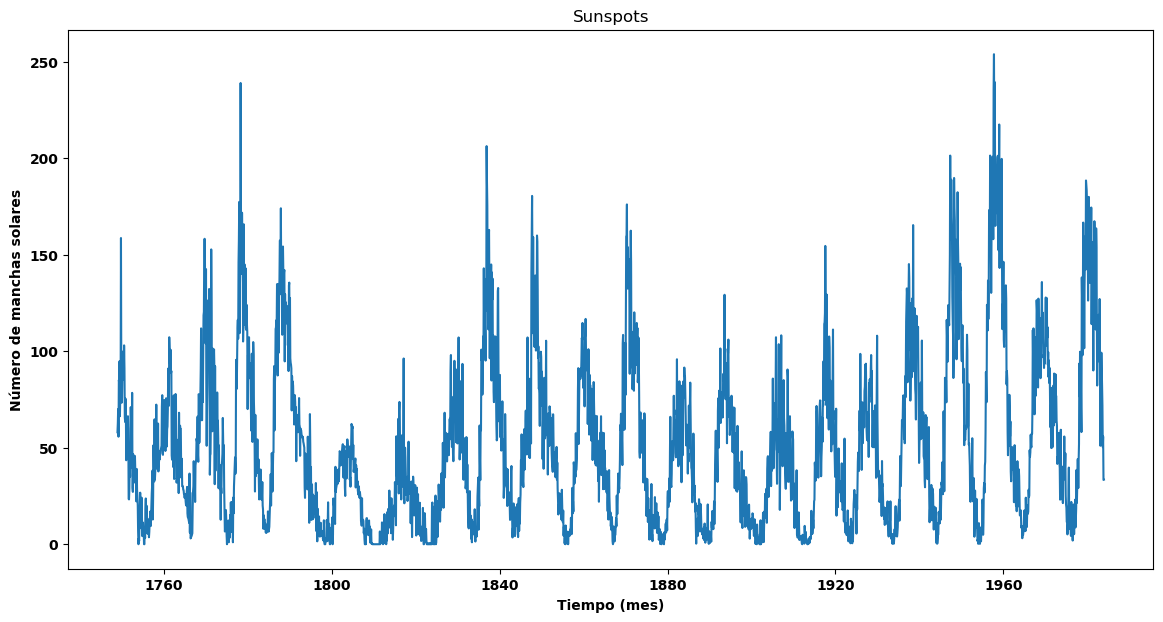

In [115]:
plt.plot(df_spot)
plt.xlabel('Tiempo (mes)')
plt.ylabel('Número de manchas solares')
plt.title('Sunspots')
plt.show()

Vamos a modelar la serie temporal con el objetivo de **predecir los valores mensuales del último año**. 

**`26.1.1`** Aplica el método de `Seasonal Naïve` a la serie temporal y consigue estos puntos **y analiza los resultados obtenidos**:
- Grafica de "_Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)_"
- Gráfica interactiva con el histórico, la predicción y los valores reales del último año. 
- Las métricas de "_Out-of-sample performance_": MAE, MAPE, MSE, RMSE y R2.

**`26.1.2`** Aplica el método de `Autoregresión - AR(24)` la serie temporal y consigue estos puntos **y analiza los resultados obtenidos**:
- Resumen del modelo ajustado (_Model fit summary_) 
- Gráfica de "_Datos reales vs. Estimación del modelo (In-Sample forecasting)_"
- Gráficas de análisis del componente residual (curvas de diagnóstico, correlaciones con otras variables)
- Gráfica de "_Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)_"
- Gráfica interactiva con el histórico, la predicción y los valores reales del último año. 
- Las métricas de "_Out-of-sample performance_": MAE, MAPE, MSE, RMSE y R2.

**`26.1.3`** Aplica el método de `SARIMA (4,1,1)(2,0,0)12` la serie temporal y consigue estos puntos **y analiza los resultados obtenidos**:
- Resumen del modelo ajustado (_Model fit summary_) 
- Gráfica de "_Datos reales vs. Estimación del modelo (In-Sample forecasting)_"
- Gráficas de análisis del componente residual (curvas de diagnóstico, correlaciones con otras variables)
- Gráfica de "_Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)_"
- Gráfica interactiva con el histórico, la predicción y los valores reales del último año. 
- Las métricas de "_Out-of-sample performance_": MAE, MAPE, MSE, RMSE y R2.

**`26.1.4`** Aplica el método de `Holt-Winters Exponential Smoothing` la serie temporal y consigue estos puntos **y analiza los resultados obtenidos**:
- Resumen del modelo ajustado (_Model fit summary_) 
- Gráfica de "_Datos reales vs. Estimación del modelo (In-Sample forecasting)_"
- Gráficas de análisis del componente residual (correlaciones con otras variables)
- Gráfica de "_Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)_"
- Gráfica interactiva con el histórico, la predicción y los valores reales del último año. 
- Las métricas de "_Out-of-sample performance_": MAE, MAPE, MSE, RMSE y R2.

---

In [171]:
## Solución 26.1.1
df_test_spot = df_spot.tail(12)
df_test_spot


Sunspots
fechas              
1983-01-01      84.3
1983-02-01      51.0
1983-03-01      66.5
1983-04-01      80.7
1983-05-01      99.2
1983-06-01      91.1
1983-07-01      82.2
1983-08-01      71.8
1983-09-01      50.3
1983-10-01      55.8
1983-11-01      33.3
1983-12-01      33.4

In [172]:
df_train_spot = df_spot.loc[df_spot.index.isin(df_test_spot.index)==False]
df_train_spot


Sunspots
fechas              
1749-01-01      58.0
1749-02-01      62.6
1749-03-01      70.0
1749-04-01      55.7
1749-05-01      85.0
...              ...
1982-08-01     107.6
1982-09-01     118.8
1982-10-01      94.7
1982-11-01      98.1
1982-12-01     127.0

[2808 rows x 1 columns]

In [173]:
pred_spot = pd.DataFrame(data=df_train_spot.tail(12).values, index=df_test_spot.index, columns=['pred'])
pred_spot

pred
fechas           
1983-01-01  111.2
1983-02-01  163.6
1983-03-01  153.8
1983-04-01  122.0
1983-05-01   82.2
1983-06-01  110.4
1983-07-01  106.1
1983-08-01  107.6
1983-09-01  118.8
1983-10-01   94.7
1983-11-01   98.1
1983-12-01  127.0

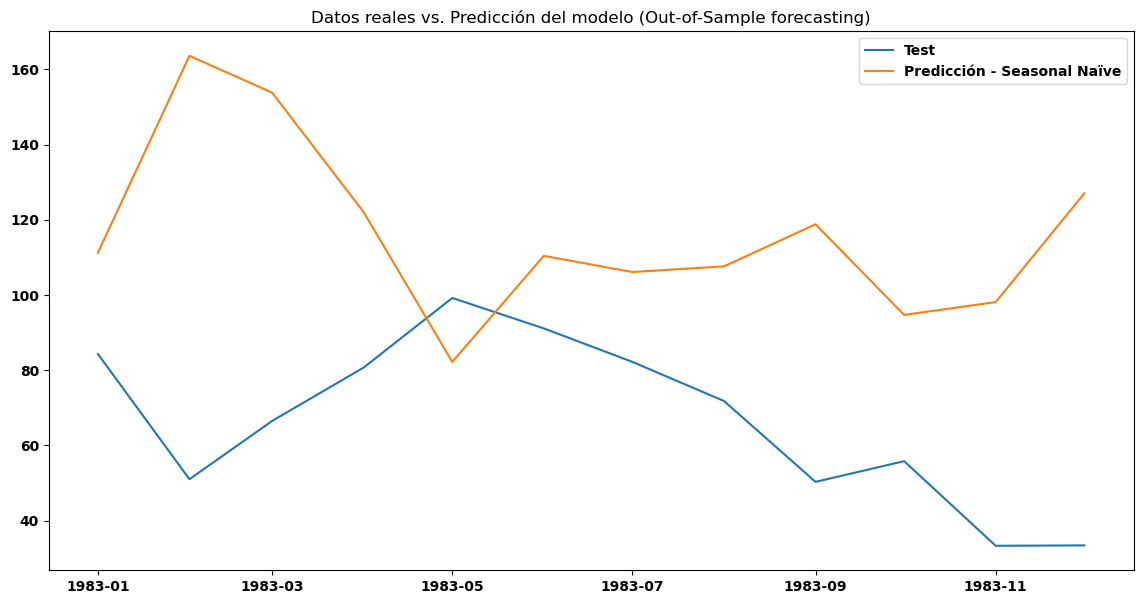

In [174]:
plt.plot(df_test_spot, label='Test')
plt.plot(pred_spot, label='Predicción - Seasonal Naïve')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

In [175]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_spot.index,
    y=df_train_spot['Sunspots'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test_spot.index,
    y=df_test_spot['Sunspots'],
    name="Test",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_spot.index,
    y=pred_spot['pred'],
    name="Predicción (Seasonal Naive)",
    mode="markers+lines"
    ))

fig.update_layout(title="Manchas solares de cada mes desde el año 1749 al 1983",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Sunspots'
                  )

fig.show()

In [211]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Out-of-sample performance:  Seasonal Naive")
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test_spot, pred_spot))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test_spot, pred_spot)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test_spot, pred_spot))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test_spot, pred_spot)))
print('R^2 coefficient of determination:', r2_score(df_test_spot, pred_spot))

Out-of-sample performance:  Seasonal Naive
Mean Absolute Error (MAE): 52.49166666666667
Mean Absolute Percentage Error (MAPE): 102.7615492933623
Mean Squared Error (MSE): 3700.7624999999994
Root Mean Squared Error (RMSE): 60.833892691492295
R^2 coefficient of determination: -7.407119211357619


#### Explicación 26.1.1
> Podemos observar una gráfica de SN que relaciona datos reales versus predichos de una forma algo erronea, donde podemos ver que la grafica de las predicciones tienen una tendencia en espejo a la de test.
>
> En la gráfica interactiva podemos observar la misma gráfica anterior. Pero puediendo analizarla de una forma más detallada.
>
> Si sacamos las métricas de sklearn podemos observar resultados bastante mediocres con un -7 de R2, y una media de error muy alta. Esto demuestra qque la prediccion no es para nada buena.

In [177]:
## Solución 26.1.2
from statsmodels.tsa.ar_model import AutoReg

modelo_ar_26_1_2 = AutoReg(df_train_spot, lags=24)
modelo_ar_26_1_2

c:\Users\aleja\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [178]:
fit_ar_26_1_2 = modelo_ar_26_1_2.fit()

estim_ar_26_1_2 = fit_ar_26_1_2.fittedvalues
estim_ar_26_1_2

fechas
1751-01-01     76.615508
1751-02-01     77.938945
1751-03-01     55.272857
1751-04-01     55.794414
1751-05-01     54.978830
                 ...    
1982-08-01    106.992668
1982-09-01    104.779365
1982-10-01    107.725277
1982-11-01    102.017089
1982-12-01     99.793929
Length: 2784, dtype: float64

In [179]:
fit_ar_26_1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               Sunspots   No. Observations:                 2808
Model:                    AutoReg(24)   Log Likelihood              -11520.417
Method:               Conditional MLE   S.D. of innovations             15.167
Date:                Sat, 23 Mar 2024   AIC                          23092.834
Time:                        13:52:28   BIC                          23247.057
Sample:                    01-01-1751   HQIC                         23148.519
                         - 12-01-1982                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.8145      0.501      7.614      0.000       2.833       4.796
Sunspots.L1      0.5394      0.019     28.515      0.000       0.502       0.576
Sunspots.L2      0.0985      0.021      4.589      0.000       0.056       0.141
Sunspots.L3      0.0834      0.022      3.870      0.000       0.041       0.126
Sunspots.L4      0.0827      0.022      3.831      0.000       0.040       0.125
Sunspots.L5      0.0428      0.022      1.978      0.048       0.000       0.085
Sunspots.L6      0.0500      0.022      2.307      0.021       0.008       0.092
Sunspots.L7      0.0103      0.022      0.477      0.634      -0.032       0.053
Sunspots.L8      0.0111      0.022      0.512      0.609      -0.031       0.054
Sunspots.L9      0.1058      0.022      4.880      0.000       0.063       0.148
Sunspots.L10     0.0251      0.022      1.153      0.249      -0.018       0.068
Sunspots.L11     0.0195      0.022      0.898      0.369      -0.023       0.062
Sunspots.L12     0.0273      0.022      1.251      0.211      -0.015       0.070
Sunspots.L13    -0.0182      0.022     -0.833      0.405      -0.061       0.025
Sunspots.L14     0.0030      0.022      0.137      0.891      -0.040       0.045
Sunspots.L15     0.0431      0.022      1.990      0.047       0.001       0.086
Sunspots.L16    -0.0320      0.022     -1.484      0.138      -0.074       0.010
Sunspots.L17    -0.0027      0.022     -0.126      0.900      -0.045       0.040
Sunspots.L18    -0.0659      0.022     -3.054      0.002      -0.108      -0.024
Sunspots.L19    -0.0012      0.022     -0.054      0.957      -0.044       0.041
Sunspots.L20    -0.0241      0.022     -1.115      0.265      -0.067       0.018
Sunspots.L21    -0.0419      0.022     -1.939      0.052      -0.084       0.000
Sunspots.L22    -0.0148      0.022     -0.688      0.492      -0.057       0.027
Sunspots.L23     0.0536      0.021      2.497      0.013       0.012       0.096
Sunspots.L24    -0.0699      0.019     -3.688      0.000      -0.107      -0.033
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0871           -0.1654j            1.0996           -0.4760
AR.2            -1.0871           +0.1654j            1.0996            0.4760
AR.3            -1.0346           -0.4536j            1.1296           -0.4342
AR.4            -1.0346           +0.4536j            1.1296            0.4342
AR.5            -0.8960           -0.6799j            1.1248           -0.3967
AR.6            -0.8960           +0.6799j            1.1248            0.3967
AR.7            -0.6366           -0.8929j            1.0966           -0.3486
AR.8            -0.6366           +0.8929j            1.0966            0.3486
AR.9            -0.3931  

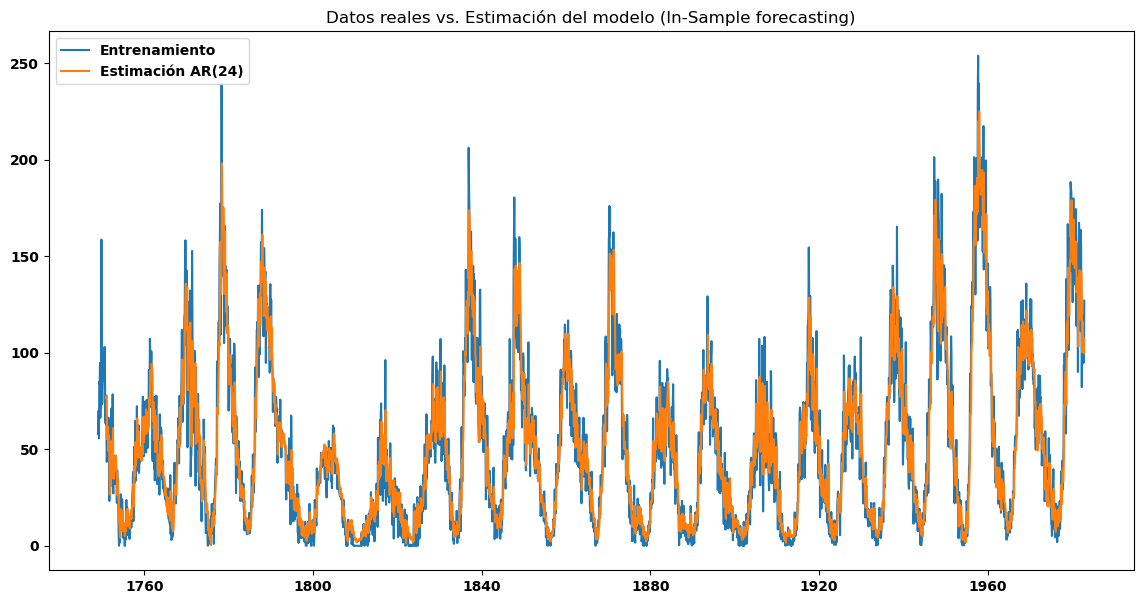

In [180]:
plt.plot(df_train_spot, label='Entrenamiento')
plt.plot(estim_ar_26_1_2, label='Estimación AR(24)')
plt.title("Datos reales vs. Estimación del modelo (In-Sample forecasting)")
plt.legend()
plt.show()

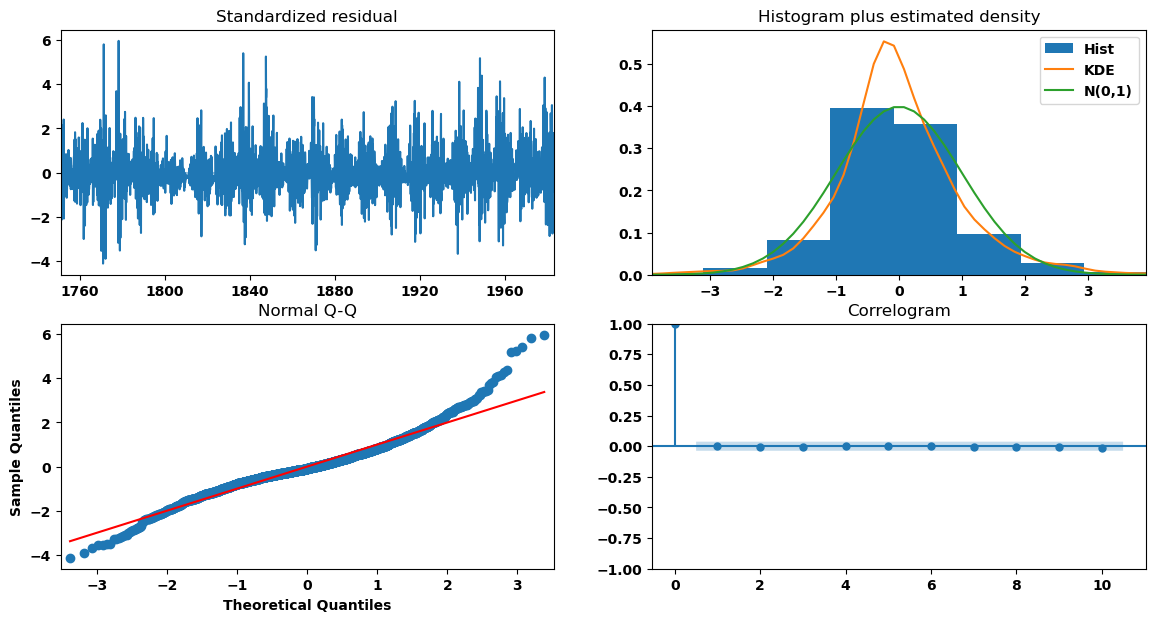

In [181]:
fit_ar_26_1_2.plot_diagnostics()
plt.show()

In [182]:
pred_ar_26_1_2 = fit_ar_26_1_2.forecast(steps=12).round()
pred_ar_26_1_2

c:\Users\aleja\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



1983-01-01    112.0
1983-02-01    100.0
1983-03-01     98.0
1983-04-01     88.0
1983-05-01     85.0
1983-06-01     86.0
1983-07-01     81.0
1983-08-01     73.0
1983-09-01     73.0
1983-10-01     70.0
1983-11-01     70.0
1983-12-01     65.0
Freq: MS, dtype: float64

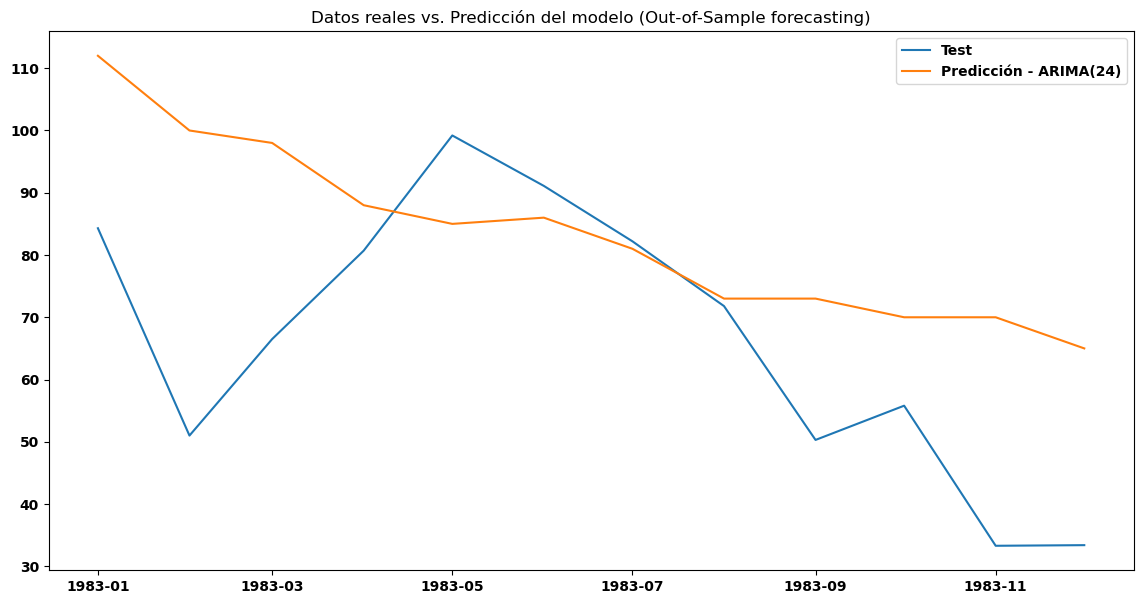

In [183]:
plt.plot(df_test_spot, label='Test')
plt.plot(pred_ar_26_1_2, label='Predicción - ARIMA(24)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

In [184]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_spot.index,
    y=df_train_spot['Sunspots'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test_spot.index,
    y=df_test_spot['Sunspots'],
    name="Test",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_ar_26_1_2.index,
    y=pred_ar_26_1_2,
    name="Predicción (AR(24))",
    mode="markers+lines"
    ))

fig.update_layout(title="Número de manchas solares de cada mes desde el año 1749 al 1983",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Manchas solares'
                  )

fig.show()

In [185]:
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test_spot, pred_ar_26_1_2))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test_spot, pred_ar_26_1_2)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test_spot, pred_ar_26_1_2))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test_spot, pred_ar_26_1_2)))
print('R^2 coefficient of determination:', r2_score(df_test_spot, pred_ar_26_1_2))

Mean Absolute Error (MAE): 20.199999999999996
Mean Absolute Percentage Error (MAPE): 40.316141978040484
Mean Squared Error (MSE): 625.5616666666667
Root Mean Squared Error (RMSE): 25.01123081071115
R^2 coefficient of determination: -0.4211048414271992


#### Explicación 26.1.2
> El resumen del ajuste, mestra un modelo de Autoreg(24) (el modelo deseado). Teniendo una gráfica entre datos reales versus la estimación, podemos observar que la tendencia de valores si es parecida a la de los datos de entrenamiento. Pero con algunos errores.
>
> En las cuatro gráficas del diagnóstico, podemos ver que la gráfica de residuos estandarizados presenta unos patrones para nada agradables, donde no se puede sacar en claro ninguna dispersión aleatoria. Por otro lado, en el histograma podemos ver una forma de campana. Pero no muy definida. Para la grafica de Q-Q podemos ver que tanto al inicio como al final, los valores se alejan de la linea recta de guía, que indicaría la buena prediccion. Por último, en la gráfica de correlación, podemos ver que se encuentran pegados al 0, lo que puede llegar a mostrar una autocorrelación.
>
> Para la gráfica de datos reales versus predicciones, vemos que la predicción tiene una tendencia de datos descendente, que en poco se parece a los datos reales. Esto se ve de una forma más detallada en la gráfica interactiva.
>
> Por último, podemos ver en las metricas valores muy malos de R2 (-0.4) y una media de error muy alta. Lo que demuestra que no es un buen modelo.

In [186]:
## Solución 26.1.3
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelo_sarimax_26_1_2 = SARIMAX(df_train_spot,
                          order=(4,1,1),
                          seasonal_order=(2,0,0,12))
modelo_sarimax_26_1_2

c:\Users\aleja\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\aleja\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [187]:
fit_sarimax_26_1_2 = modelo_sarimax_26_1_2.fit()

estim_sarimax_26_1_2 = fit_sarimax_26_1_2.fittedvalues
estim_sarimax_26_1_2

fechas
1749-01-01      0.000000
1749-02-01     57.994849
1749-03-01     61.216102
1749-04-01     66.370182
1749-05-01     58.658296
                 ...    
1982-08-01    113.137477
1982-09-01    109.408319
1982-10-01    114.709096
1982-11-01    100.682251
1982-12-01    100.907895
Length: 2808, dtype: float64

In [188]:
fit_sarimax_26_1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Sunspots   No. Observations:                 2808
Model:             SARIMAX(4, 1, 1)x(2, 0, [], 12)   Log Likelihood              -11716.900
Date:                             Sat, 23 Mar 2024   AIC                          23449.800
Time:                                     13:52:32   BIC                          23497.319
Sample:                                 01-01-1749   HQIC                         23466.950
                                      - 12-01-1982                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1002      0.108      0.925      0.355      -0.112       0.312
ar.L2         -0.0857      0.047     -1.822      0.069      -0.178       0.007
ar.L3         -0.0593      0.034     -1.760      0.078      -0.125       0.007
ar.L4         -0.0048      0.029     -0.164      0.870      -0.062       0.052
ma.L1         -0.5140      0.108     -4.768      0.000      -0.725      -0.303
ar.S.L12       0.0696      0.016      4.479      0.000       0.039       0.100
ar.S.L24      -0.0436      0.017     -2.602      0.009      -0.077      -0.011
sigma2       247.2289      4.138     59.750      0.000     239.119     255.339
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1356.13
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

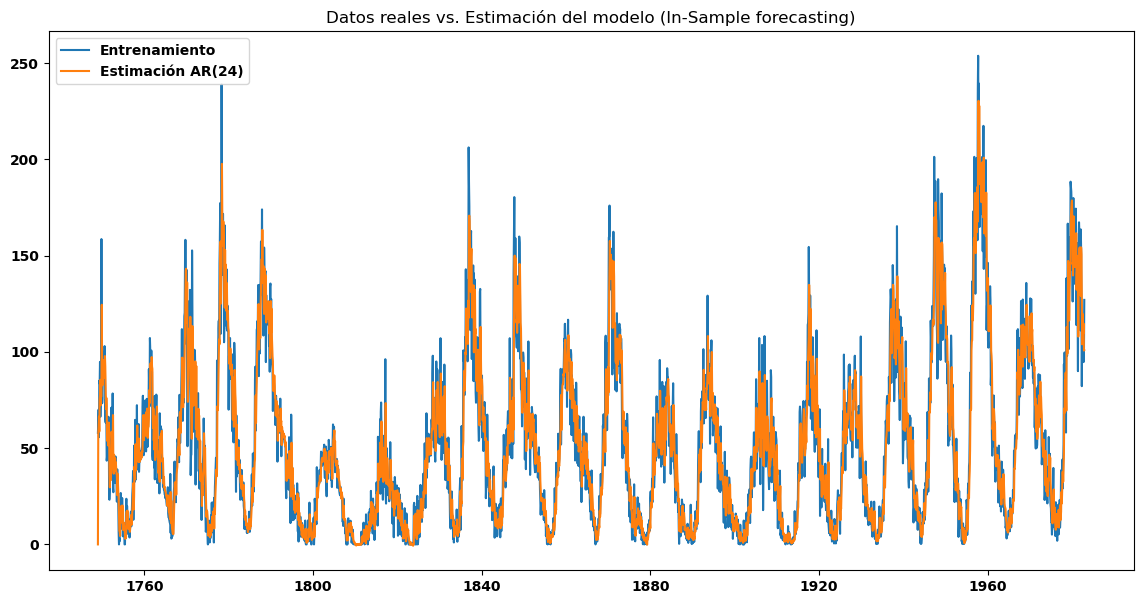

In [189]:
plt.plot(df_train_spot, label='Entrenamiento')
plt.plot(estim_sarimax_26_1_2, label='Estimación AR(24)')
plt.title("Datos reales vs. Estimación del modelo (In-Sample forecasting)")
plt.legend()
plt.show()

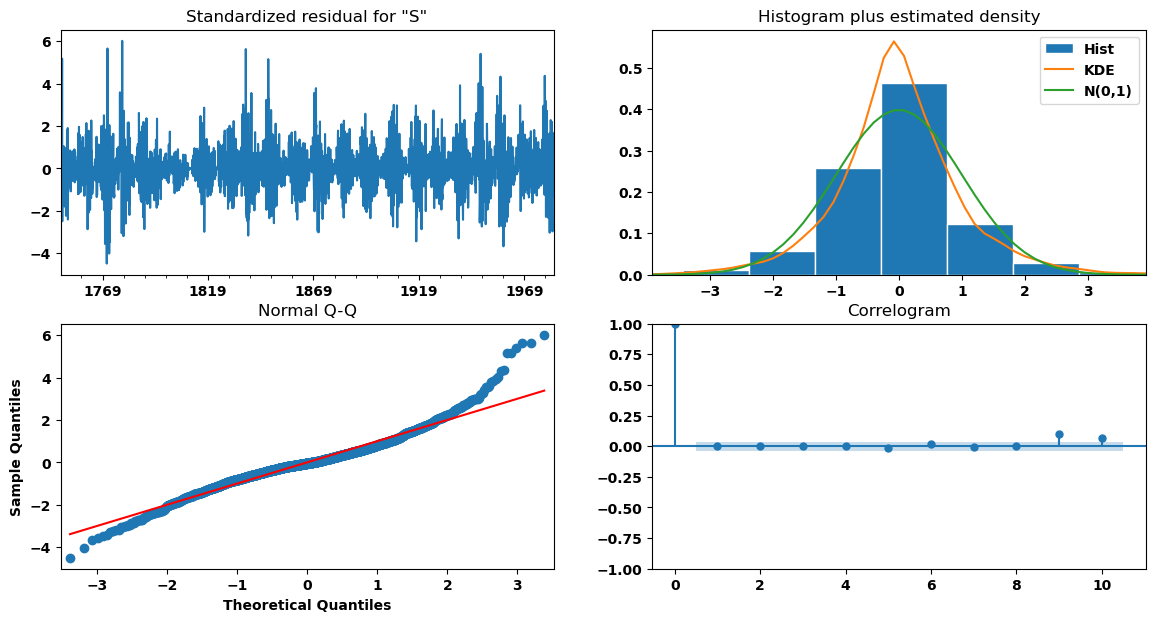

In [190]:
fit_sarimax_26_1_2.plot_diagnostics()
plt.show()

In [191]:
pred_sarimax_26_1_2 = fit_sarimax_26_1_2.forecast(steps=12).round()
pred_sarimax_26_1_2

1983-01-01    117.0
1983-02-01    116.0
1983-03-01    115.0
1983-04-01    112.0
1983-05-01    111.0
1983-06-01    115.0
1983-07-01    112.0
1983-08-01    111.0
1983-09-01    112.0
1983-10-01    110.0
1983-11-01    112.0
1983-12-01    113.0
Freq: MS, Name: predicted_mean, dtype: float64

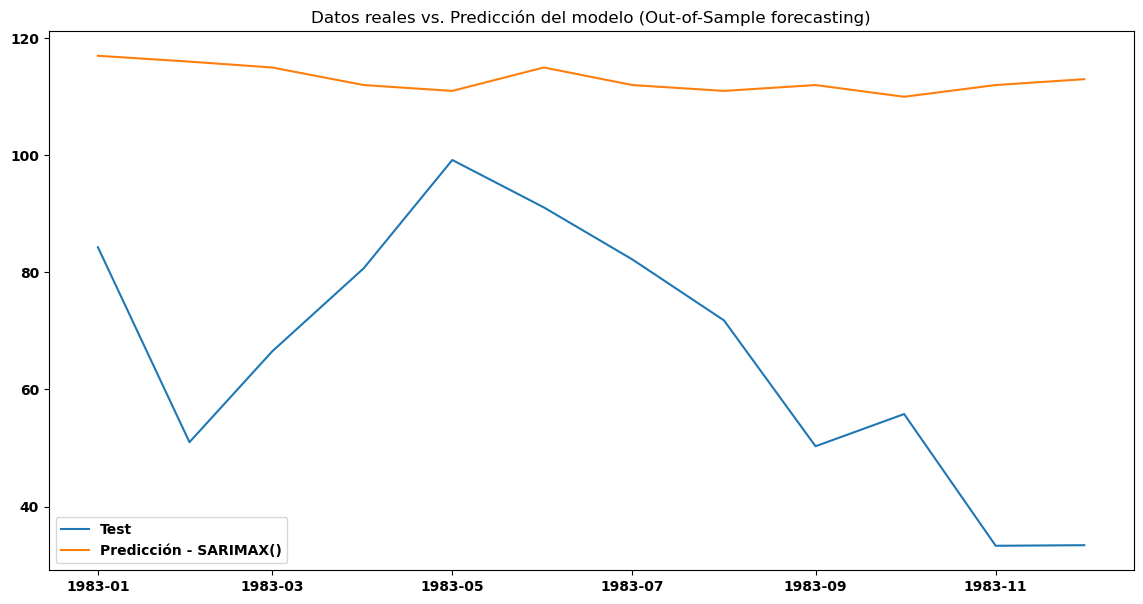

In [192]:
plt.plot(df_test_spot, label='Test')
plt.plot(pred_sarimax_26_1_2, label='Predicción - SARIMAX()')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

In [193]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_spot.index,
    y=df_train_spot['Sunspots'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test_spot.index,
    y=df_test_spot['Sunspots'],
    name="Test",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_sarimax_26_1_2.index,
    y=pred_sarimax_26_1_2,
    name="Predicción (SARIMAX)",
    mode="markers+lines"
    ))

fig.update_layout(title="Número de manchas solares de cada mes desde el año 1749 al 1983",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Manchas solares'
                  )

fig.show()

In [194]:
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test_spot, pred_sarimax_26_1_2))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test_spot, pred_sarimax_26_1_2)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test_spot, pred_sarimax_26_1_2))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test_spot, pred_sarimax_26_1_2)))
print('R^2 coefficient of determination:', r2_score(df_test_spot, pred_sarimax_26_1_2))

Mean Absolute Error (MAE): 46.36666666666667
Mean Absolute Percentage Error (MAPE): 91.78287535250055
Mean Squared Error (MSE): 2586.311666666667
Root Mean Squared Error (RMSE): 50.85579285260104
R^2 coefficient of determination: -4.875392030532


#### Explicación 26.1.3
> Podemos observar en el resumen del modelo que efectivamente de trata de un modelo SARIMAX(4,1,1)x(2,0,0,12).
>
> Para la gráfica de datos reales versus la estimación del modelo, vemos que las estimaciones tienen una tendencia que sigue a los datos reales, pero que sigue mostrando ciertas diferencias.
>
> Para las cuatro gráficas de diagnóstico, podemos hacer exactamente el mismo análisis que en el ejercicio anterior, solo pudiendo destacar diferencias mínimas.
>
> Tanto en la gráfica de datos rales versus predicciones del modelo, y más detalladamente en la gráfica interactiva. Podemos observar que las predicciones no muestran ningun tipo de criterio, mostrando una línea relativamente recta, cuando los datos reales no muestran dicha tendencia.
>
> Por último, volvemos a destacar unas métricas muy malas, con un R2 de -4. Y un porcentaje de error muy alto.

In [195]:
## Solución 26.1.4
from statsmodels.tsa.holtwinters import ExponentialSmoothing

modelo_exp_26_1_4 = ExponentialSmoothing(df_train_spot,
                                        trend='add',
                                        seasonal='add',
                                        seasonal_periods=12)

modelo_exp_26_1_4

c:\Users\aleja\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [196]:
fit_exp_26_1_4 = modelo_exp_26_1_4.fit()

estim_exp_26_1_4 = fit_exp_26_1_4.fittedvalues
estim_exp_26_1_4

fechas
1749-01-01     74.651538
1749-02-01     62.404492
1749-03-01     65.969612
1749-04-01     66.545936
1749-05-01     63.845755
                 ...    
1982-08-01    109.862582
1982-09-01    116.772211
1982-10-01    109.984916
1982-11-01     91.422638
1982-12-01    101.324678
Length: 2808, dtype: float64

In [197]:
fit_exp_26_1_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                 Sunspots   No. Observations:                 2808
Model:             ExponentialSmoothing   SSE                         750166.551
Optimized:                         True   AIC                          15722.606
Trend:                         Additive   BIC                          15817.650
Seasonal:                      Additive   AICC                         15722.852
Seasonal Periods:                    12   Date:                 Sat, 23 Mar 2024
Box-Cox:                          False   Time:                         13:52:34
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4925451                alpha                 True
smoothing_trend               0.0340978                 beta                 True
smoothing_seasonal            0.0608862                gamma                 True
initial_level                 79.600895                  l.0                 True
initial_trend                -1.2319977                  b.0                 True
initial_seasons.0            -3.7173590                  s.0                 True
initial_seasons.1            -6.2511157                  s.1                 True
initial_seasons.2            -1.2739200                  s.2                 True
initial_seasons.3            -1.2420610                  s.3                 True
initial_seasons.4             3.0227078                  s.4                 True
initial_seasons.5            -1.1118906                  s.5                 True
initial_seasons.6             6.1740928                  s.6                 True
initial_seasons.7             0.3593408                  s.7                 True
initial_seasons.8            -2.2552075                  s.8                 True
initial_seasons.9            -4.1038120                  s.9                 True
initial_seasons.10            8.5910490                 s.10                 True
initial_seasons.11            0.7234607                 s.11                 True
---------------------------------------------------------------------------------
"""

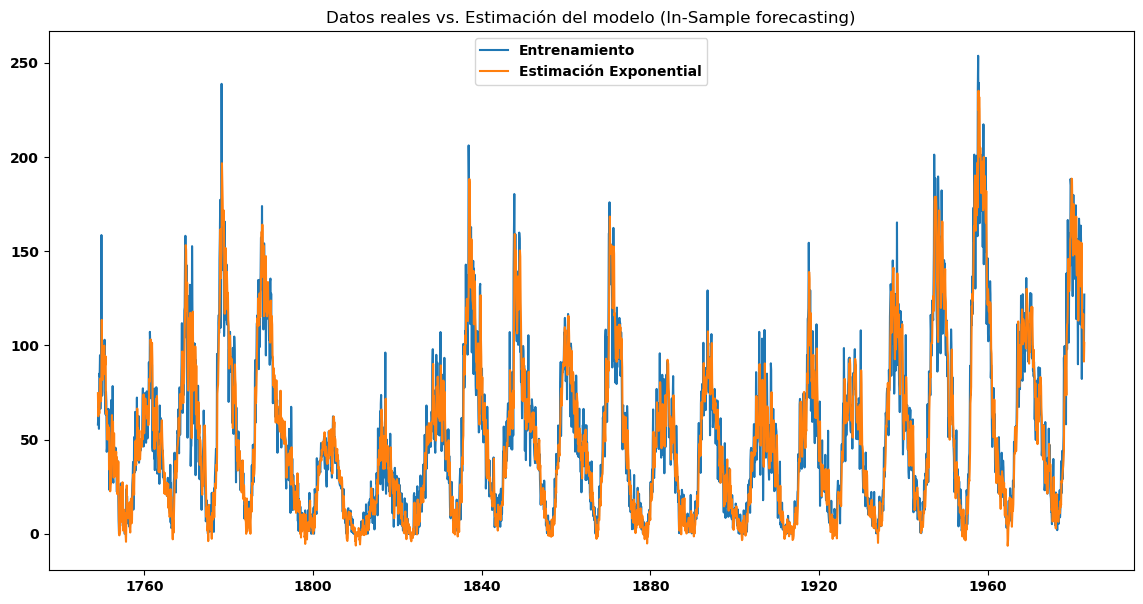

In [198]:
plt.plot(df_train_spot, label='Entrenamiento')
plt.plot(estim_exp_26_1_4, label='Estimación Exponential')
plt.title("Datos reales vs. Estimación del modelo (In-Sample forecasting)")
plt.legend()
plt.show()

In [199]:
resid_exp_26_1_4 = fit_exp_26_1_4.resid
resid_exp_26_1_4.describe()

count    2808.000000
mean        0.021075
std        16.347723
min       -70.725302
25%        -8.523737
50%         0.145859
75%         8.382185
max        88.724231
dtype: float64

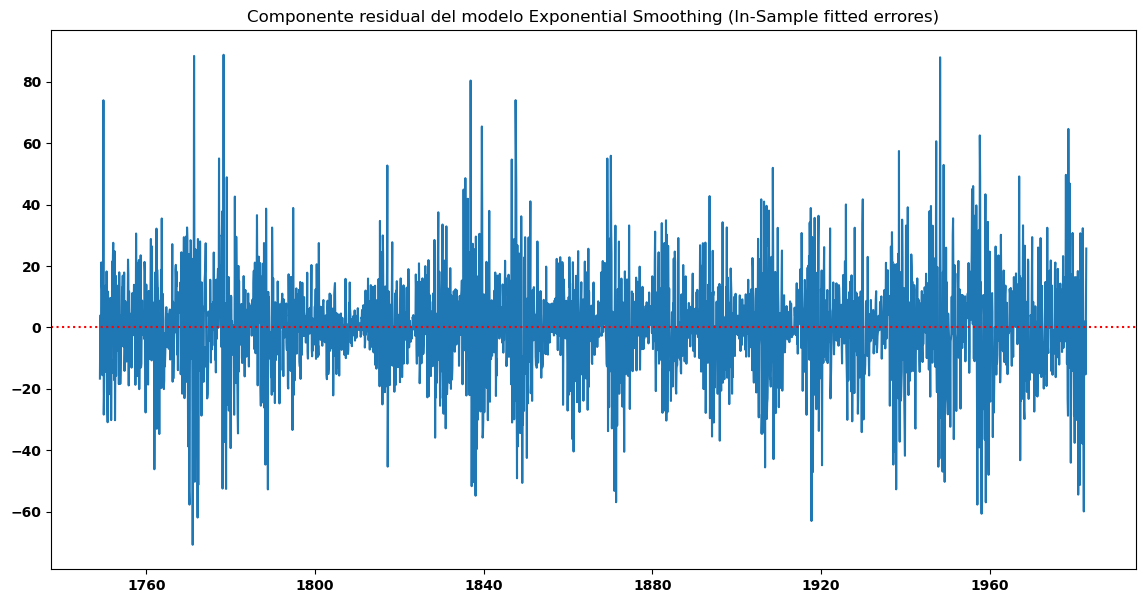

In [200]:
plt.plot(resid_exp_26_1_4)
plt.title("Componente residual del modelo Exponential Smoothing (In-Sample fitted errores)")
plt.axhline(y=0, color='r', linestyle=':')
plt.show()

c:\Users\aleja\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



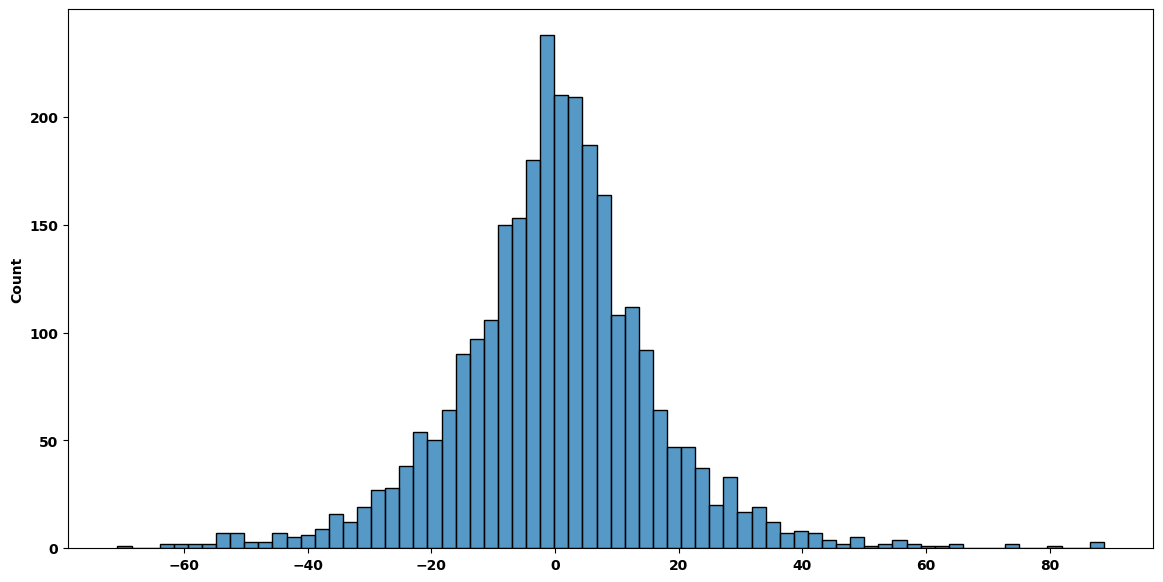

In [201]:
sns.histplot(data=resid_exp_26_1_4, bins=70)
plt.show()

c:\Users\aleja\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



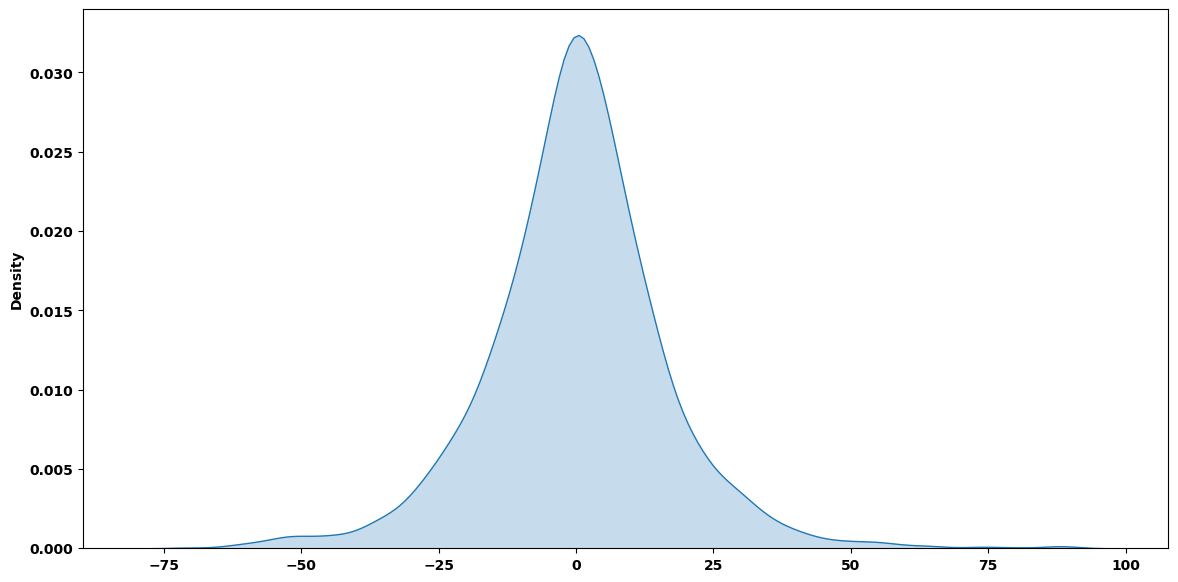

In [202]:
sns.kdeplot(data=resid_exp_26_1_4, fill=True)
plt.show()

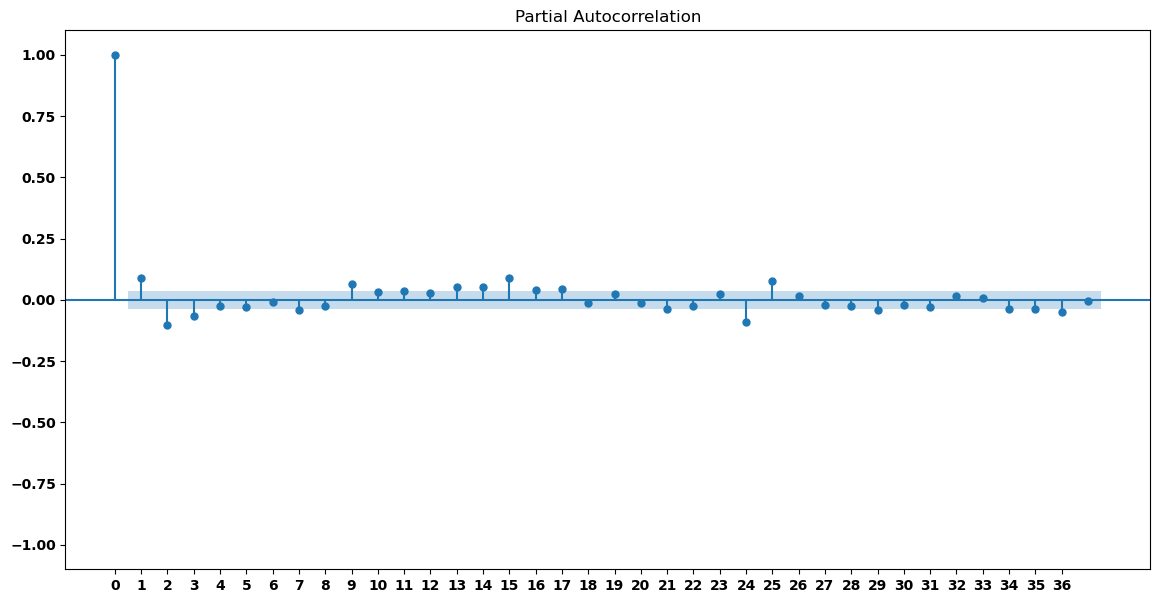

In [203]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(resid_exp_26_1_4, lags=37, method='ywm')
plt.xticks(np.arange(37))
plt.ylim(-1.1,1.1)
plt.show()

0.17


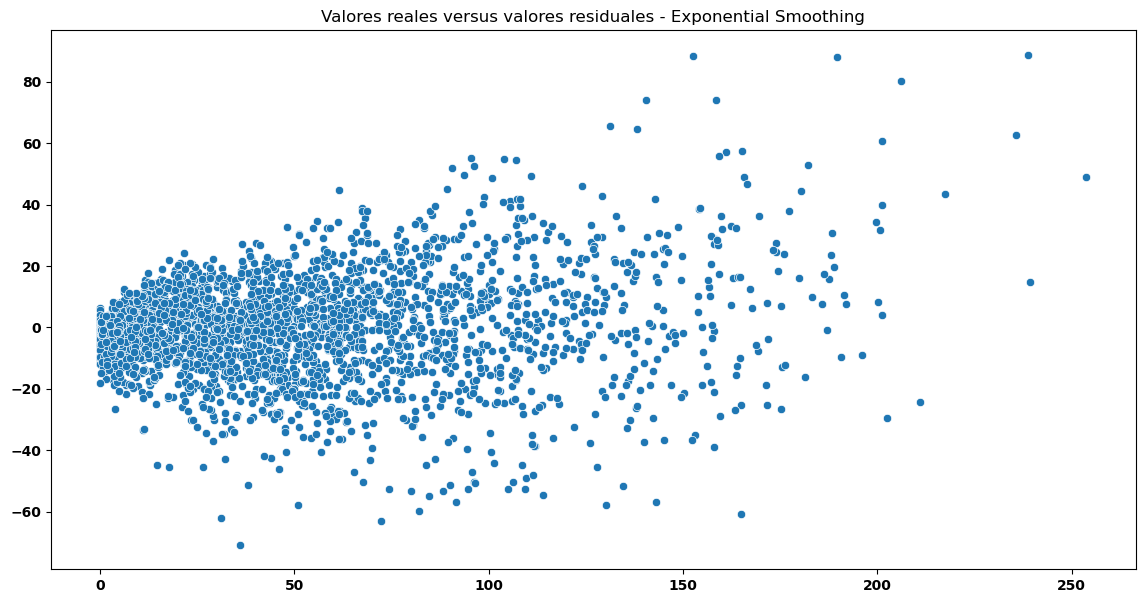

In [204]:
print(df_train_spot['Sunspots'].corr(resid_exp_26_1_4).round(4))

sns.scatterplot(x=df_train_spot.values.flatten(), y=resid_exp_26_1_4)
plt.title("Valores reales versus valores residuales - Exponential Smoothing")
plt.show()

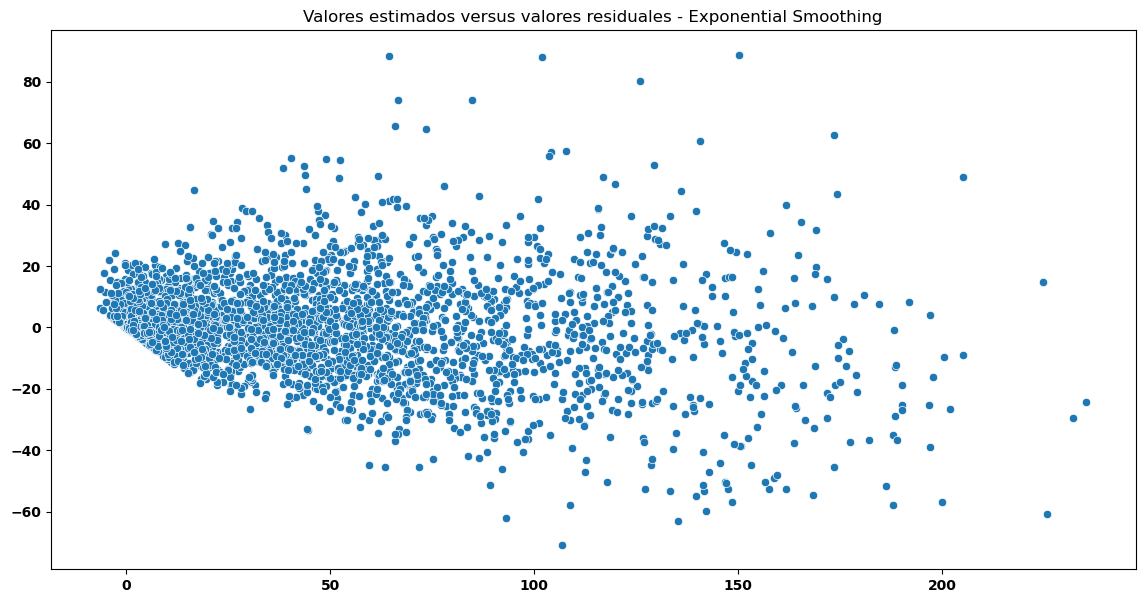

-0.2044


In [205]:
sns.scatterplot(x=estim_exp_26_1_4, y=resid_exp_26_1_4)
plt.title("Valores estimados versus valores residuales - Exponential Smoothing")
plt.show()

print(estim_exp_26_1_4.corr(resid_exp_26_1_4).round(4))

In [206]:
pred_exp_26_1_4 = fit_exp_26_1_4.forecast(steps=12).round()
pred_exp_26_1_4

1983-01-01    108.0
1983-02-01    113.0
1983-03-01    107.0
1983-04-01    109.0
1983-05-01    110.0
1983-06-01    111.0
1983-07-01    112.0
1983-08-01    114.0
1983-09-01    122.0
1983-10-01    114.0
1983-11-01    104.0
1983-12-01    111.0
Freq: MS, dtype: float64

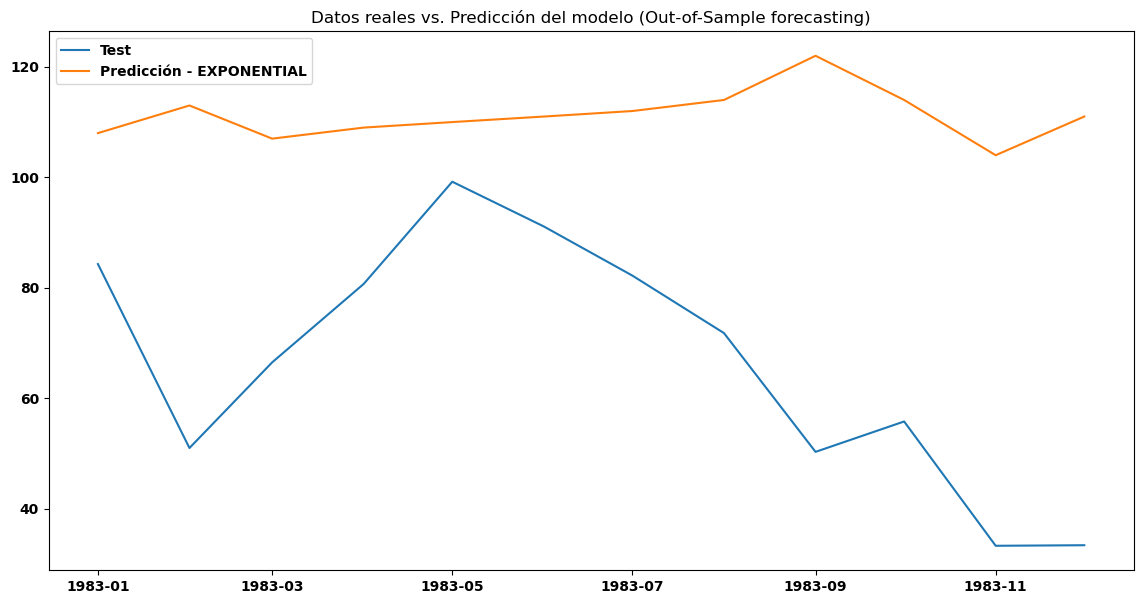

In [207]:
plt.plot(df_test_spot, label='Test')
plt.plot(pred_exp_26_1_4, label='Predicción - EXPONENTIAL')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

In [208]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train_spot.index,
    y=df_train_spot['Sunspots'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test_spot.index,
    y=df_test_spot['Sunspots'],
    name="Test",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=pred_exp_26_1_4.index,
    y=pred_exp_26_1_4,
    name="Predicción (Exponential)",
    mode="markers+lines"
    ))

fig.update_layout(title="Número de manchas solares de cada mes desde el año 1749 al 1983",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Manchas solares'
                  )

fig.show()

In [209]:
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test_spot, pred_exp_26_1_4))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(df_test_spot, pred_exp_26_1_4)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test_spot, pred_exp_26_1_4))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test_spot, pred_exp_26_1_4)))
print('R^2 coefficient of determination:', r2_score(df_test_spot, pred_exp_26_1_4))

Mean Absolute Error (MAE): 44.61666666666667
Mean Absolute Percentage Error (MAPE): 88.74208358419287
Mean Squared Error (MSE): 2464.7283333333335
Root Mean Squared Error (RMSE): 49.6460303884745
R^2 coefficient of determination: -4.5991879840827705


#### Explicación 26.1.4
> Para el modelo de ExponentialSmoothing, podemos observar un resumen que confirma, entre otras cosas, el periodo de 12 periodos que hemos asignado al modelo.
>
> Una vez más, encontramos una tendencia para las estimaciones que tiene un parecido con los datos reales, pero con rrores notables aún.
>
> En este caso, no podemos obtener las cuatro gráficas de diagnóstico directamente, sino que ha sido necesario obtenerlas una a una. En este caso, a pesar de que algunas gráficas tienen parecido con las de los ejercicios anteriores. Ahora podemos destacar un histograma con una campana mucho más definida. O una gráfica de correlación donde, aun teniendo valores cercanos al 0. Podemos ver que es mucho más dificil identificar unos patrones o desviaciones claras.
>
> Tanto en las gráficas interactivas (de una forma más detallada) como en la gráfica de datos reales versus predicciones del modelo, podemos observar que las predicciones no se acercan en absolto a los datos reales, teniendo una gráfica bastante recta (oscilante entre 100 y 120), mientras que los datos reales estan muy alejados de tener esa tendencia.
>
>Por último, destacamos unas métricas con valores igual de malos, con un R2 e -4,6 aproximadamente, y un porcentaje de error muy alto.